In [1]:
# 基本庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

# Darts - 時間序列相關庫
import darts
from darts import TimeSeries, concatenate
from darts.models import (
    DLinearModel, LightGBMModel, BlockRNNModel, TiDEModel, 
    Prophet, AutoARIMA, ARIMA
)
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics.metrics import mape, mae, mse, ape
from darts.logging import get_logger, raise_log, raise_if_not

# Scikit-learn - 數據預處理
from sklearn.preprocessing import MinMaxScaler
from tools.callbacks import LossLoggingCallback
from tools.calculate_95_ci import calculate_95_ci
from tools.calculate_metrics import calculate_metrics
from tools.data_loader import load_and_preprocess_data

import torch
import torch.optim as optim

In [2]:
 print(torch.cuda.is_available())  # 如果結果是 True，表示 GPU 可用

True


In [3]:
location = 'Taipei' 
model_type = 'DLinear' 
location_params = {
    'Linkou': {'train_end': 3362, 'val_end': 3727},
    'Taipei': {'train_end': 3372, 'val_end': 3737},
    'Kaohsiung': {'train_end': 3208, 'val_end': 3573},
    'Keelung': {'train_end': 3274, 'val_end': 3639},
    'Yunlin': {'train_end': 2557, 'val_end': 2922},
    'Chiayi': {'train_end': 3237, 'val_end': 3602}
}

#Data preprocess

In [5]:
train_series_scaled, test_series_scaled, combined_series_scaled, train_series, test_series, combined_series, ED_covariates, scaler = load_and_preprocess_data(location)

#Model

In [7]:
loss_logging_callback = LossLoggingCallback()

model = DLinearModel(
    input_chunk_length=30,
    output_chunk_length=7,
    batch_size=128,
    kernel_size=25,
    optimizer_cls=optim.Adam,  # 使用 Adam 优化器
    optimizer_kwargs={"lr": 0.0006644269175139048}, 
    save_checkpoints=True,
    pl_trainer_kwargs = {
    "max_epochs": 15,
    "callbacks": [loss_logging_callback]},)

In [8]:
forecast_horizon =7       
retrain = 1
stride = 7
train_length = location_params[location]['train_end']

# Assuming 'test_series' and 'ED_covariates' are properly defined Darts TimeSeries objects
# Perform the historical forecast
backtest_series = model.historical_forecasts(
    series=combined_series_scaled,
    past_covariates=ED_covariates,
    forecast_horizon=forecast_horizon,
    stride=stride,
    retrain=retrain,
    start=pd.Timestamp('2018-01-01'),
    train_length = train_length,
    verbose=True,
    last_points_only=False,
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/247 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_s

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0045142138907529735


C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?


Epoch 1: train_loss=0.0022196603870879776
Epoch 2: train_loss=0.0025215693634729136
Epoch 3: train_loss=0.0021201042415266895
Epoch 4: train_loss=0.004600505042190598
Epoch 5: train_loss=0.0023800776121285895
Epoch 6: train_loss=0.0017266185083472086
Epoch 7: train_loss=0.0016753118381831141
Epoch 8: train_loss=0.002912116773277081
Epoch 9: train_loss=0.002136966941051707
Epoch 10: train_loss=0.0015818722287216918
Epoch 11: train_loss=0.0015158696991294399
Epoch 12: train_loss=0.0037128084920324475
Epoch 13: train_loss=0.0029636151903903074


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019376399102281612


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.001978230075335491
Epoch 1: train_loss=0.0032687769512497553
Epoch 2: train_loss=0.004942462027589399
Epoch 3: train_loss=0.0020594121267281263
Epoch 4: train_loss=0.0033509515296441254
Epoch 5: train_loss=0.005894424455517755
Epoch 6: train_loss=0.0022985306290115625
Epoch 7: train_loss=0.0035031526509204944
Epoch 8: train_loss=0.003781208769215724
Epoch 9: train_loss=0.006356816672188677
Epoch 10: train_loss=0.003211393410956315
Epoch 11: train_loss=0.0031309157589525364
Epoch 12: train_loss=0.002024545113682641
Epoch 13: train_loss=0.006334963868015902


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00221953944597595


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004467817472831617
Epoch 1: train_loss=0.004008164284589759
Epoch 2: train_loss=0.0030297117071318436
Epoch 3: train_loss=0.0025613763902351846
Epoch 4: train_loss=0.0025013656996971914
Epoch 5: train_loss=0.004769643362790468
Epoch 6: train_loss=0.0022364358214623527
Epoch 7: train_loss=0.0038347979917915686
Epoch 8: train_loss=0.0018756589254133717
Epoch 9: train_loss=0.003262154630532156
Epoch 10: train_loss=0.004780403297227949
Epoch 11: train_loss=0.0013139389069481884
Epoch 12: train_loss=0.003218847320553589
Epoch 13: train_loss=0.001783517585221219


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0038633113711209134


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0040076206574545
Epoch 1: train_loss=0.004065714151479758
Epoch 2: train_loss=0.0034276038055392703
Epoch 3: train_loss=0.0020972797632664996
Epoch 4: train_loss=0.0017955244286360843
Epoch 5: train_loss=0.0027805119416274364
Epoch 6: train_loss=0.0011177038278975611
Epoch 7: train_loss=0.001671428249472519
Epoch 8: train_loss=0.0021307822067180475
Epoch 9: train_loss=0.0020648074952084663
Epoch 10: train_loss=0.001873897806758307
Epoch 11: train_loss=0.0020682739946453342
Epoch 12: train_loss=0.0017619183733817054
Epoch 13: train_loss=0.005043740714763207


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018867139752963388


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003490702113276894
Epoch 1: train_loss=0.0035361421528197217
Epoch 2: train_loss=0.004038800690021977
Epoch 3: train_loss=0.004495804267030024
Epoch 4: train_loss=0.0015610989927171822
Epoch 5: train_loss=0.0021878133510810412
Epoch 6: train_loss=0.002046049551856282
Epoch 7: train_loss=0.0034769764546265206
Epoch 8: train_loss=0.002168670810983731
Epoch 9: train_loss=0.0029288111400049503
Epoch 10: train_loss=0.0020177349825344286
Epoch 11: train_loss=0.0026510776385794844
Epoch 12: train_loss=0.002223165774882911
Epoch 13: train_loss=0.0026721648421636534


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003086837819732848


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0035800392392095143
Epoch 1: train_loss=0.0033056988931900355
Epoch 2: train_loss=0.002308998272059837
Epoch 3: train_loss=0.01405543849188234
Epoch 4: train_loss=0.015416108911450462
Epoch 5: train_loss=0.003733708697368719
Epoch 6: train_loss=0.018925883092502517
Epoch 7: train_loss=0.0029506301083553925
Epoch 8: train_loss=0.0015723192758051933
Epoch 9: train_loss=0.001499068098546606
Epoch 10: train_loss=0.002737756731376009
Epoch 11: train_loss=0.001458408907433125
Epoch 12: train_loss=0.0025322366859386568
Epoch 13: train_loss=0.002270153498449949


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.006063118864646474


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006029646389121847
Epoch 1: train_loss=0.005112030023262092
Epoch 2: train_loss=0.004908232657788686
Epoch 3: train_loss=0.0026048973835812077
Epoch 4: train_loss=0.0023972802946029812
Epoch 5: train_loss=0.0009919072570322154
Epoch 6: train_loss=0.0024048249719509068
Epoch 7: train_loss=0.0013573159235476134
Epoch 8: train_loss=0.002489752952342368
Epoch 9: train_loss=0.0015942557925220844
Epoch 10: train_loss=0.0022712819122529824
Epoch 11: train_loss=0.003587152290133031
Epoch 12: train_loss=0.0049360595269872755
Epoch 13: train_loss=0.0025061164350019577


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021844149844983288


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01013722803613015
Epoch 1: train_loss=0.0034064857039291974
Epoch 2: train_loss=0.003215906008768988
Epoch 3: train_loss=0.0018500466218162777
Epoch 4: train_loss=0.0027925285257918192
Epoch 5: train_loss=0.001971583796507614
Epoch 6: train_loss=0.0030389196304943964
Epoch 7: train_loss=0.001964368078085718
Epoch 8: train_loss=0.002867060979224828
Epoch 9: train_loss=0.002374296384868563
Epoch 10: train_loss=0.0014926461413107986
Epoch 11: train_loss=0.0035095839568260916
Epoch 12: train_loss=0.00407192113355221
Epoch 13: train_loss=0.004656739557052369


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017033005715483174


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009387273285325641
Epoch 1: train_loss=0.004808522455382452
Epoch 2: train_loss=0.0049597680995788155
Epoch 3: train_loss=0.001347024955911655
Epoch 4: train_loss=0.0023406245693945948
Epoch 5: train_loss=0.003157863372107395
Epoch 6: train_loss=0.0025484105112123707
Epoch 7: train_loss=0.001690622340255775
Epoch 8: train_loss=0.0025926091510593942
Epoch 9: train_loss=0.005119418767836201
Epoch 10: train_loss=0.004514819784959415
Epoch 11: train_loss=0.0019583113918445337
Epoch 12: train_loss=0.002436033169375457
Epoch 13: train_loss=0.0034083057897850034


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0031898878185979782


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006817180394487738
Epoch 1: train_loss=0.003639950718346848
Epoch 2: train_loss=0.009413999157582916
Epoch 3: train_loss=0.003581300492378701
Epoch 4: train_loss=0.002991486468811956
Epoch 5: train_loss=0.001485125599434359
Epoch 6: train_loss=0.0019104611147866012
Epoch 7: train_loss=0.0042632152571609495
Epoch 8: train_loss=0.003290145302068745
Epoch 9: train_loss=0.002490182855271686
Epoch 10: train_loss=0.004209378570378081
Epoch 11: train_loss=0.0025535715799815998
Epoch 12: train_loss=0.0021190922210457363
Epoch 13: train_loss=0.001748618169859084


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019160405189027835


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0041027364764166145
Epoch 1: train_loss=0.0029535548750137994
Epoch 2: train_loss=0.005535297692244211
Epoch 3: train_loss=0.003473301269239612
Epoch 4: train_loss=0.0013899699272613272
Epoch 5: train_loss=0.002012293533260307
Epoch 6: train_loss=0.001967075227013054
Epoch 7: train_loss=0.0058757407338033045
Epoch 8: train_loss=0.005088307787857783
Epoch 9: train_loss=0.0019141624677171181
Epoch 10: train_loss=0.005874702809742353
Epoch 11: train_loss=0.013702581049273457
Epoch 12: train_loss=0.004021465085084374
Epoch 13: train_loss=0.008839781254662357


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001650392616003886


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0092691590614977
Epoch 1: train_loss=0.004148262698906485
Epoch 2: train_loss=0.0035923506897478693
Epoch 3: train_loss=0.003049790806751333
Epoch 4: train_loss=0.0037877284157156036
Epoch 5: train_loss=0.0015522281872119837
Epoch 6: train_loss=0.004364418682462241
Epoch 7: train_loss=0.002706798725470399
Epoch 8: train_loss=0.002637398341075181
Epoch 9: train_loss=0.0020571642383751423
Epoch 10: train_loss=0.0030948061360204205
Epoch 11: train_loss=0.002689372623196328
Epoch 12: train_loss=0.0017649988876887789
Epoch 13: train_loss=0.0024204714107469525


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001710825189856391


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0029828017395885716
Epoch 1: train_loss=0.006146477533947347
Epoch 2: train_loss=0.003799330081131017
Epoch 3: train_loss=0.004064009448690189
Epoch 4: train_loss=0.0014923227504096055
Epoch 5: train_loss=0.00444340364548441
Epoch 6: train_loss=0.0036592248145261596
Epoch 7: train_loss=0.002948712681490504
Epoch 8: train_loss=0.0013846901206224563
Epoch 9: train_loss=0.0018902691818854622
Epoch 10: train_loss=0.002318749507170433
Epoch 11: train_loss=0.003325955337060939
Epoch 12: train_loss=0.0028493604398749876
Epoch 13: train_loss=0.0017801904256357626


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.020780926492955015


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0018621341991765592
Epoch 1: train_loss=0.0015586239009751602
Epoch 2: train_loss=0.013139435374656958
Epoch 3: train_loss=0.0026489628606847938
Epoch 4: train_loss=0.002391777933690537
Epoch 5: train_loss=0.002689077634770751
Epoch 6: train_loss=0.0025188402683559755
Epoch 7: train_loss=0.001459292396279456
Epoch 8: train_loss=0.0016450388697443468
Epoch 9: train_loss=0.003855011646023232
Epoch 10: train_loss=0.001729339456243826
Epoch 11: train_loss=0.0022378660307622086
Epoch 12: train_loss=0.007451885903082025
Epoch 13: train_loss=0.0014985776966017863


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002577853394822713


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004790265081035904
Epoch 1: train_loss=0.008958890125844589
Epoch 2: train_loss=0.00922314551753147
Epoch 3: train_loss=0.0015139294291137678
Epoch 4: train_loss=0.00463497631754984
Epoch 5: train_loss=0.0026190403754842526
Epoch 6: train_loss=0.0020644679736262403
Epoch 7: train_loss=0.0017083965768503763
Epoch 8: train_loss=0.0024950787399602697
Epoch 9: train_loss=0.0022028812035437446
Epoch 10: train_loss=0.0024956436990452384
Epoch 11: train_loss=0.0024696238843333277
Epoch 12: train_loss=0.0039311254178978836
Epoch 13: train_loss=0.0018485545994138045


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033610037672202765


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0037342888999060365
Epoch 1: train_loss=0.02203571385432111
Epoch 2: train_loss=0.02414502549072083
Epoch 3: train_loss=0.001348206341750905
Epoch 4: train_loss=0.0028074287357314222
Epoch 5: train_loss=0.0019179482954135136
Epoch 6: train_loss=0.0019932394787469123
Epoch 7: train_loss=0.00398582514239899
Epoch 8: train_loss=0.002268697314623346
Epoch 9: train_loss=0.002031237829411507
Epoch 10: train_loss=0.0020418387023040914
Epoch 11: train_loss=0.0033828752686575103
Epoch 12: train_loss=0.002869148095503672
Epoch 13: train_loss=0.002156199071502138


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002001071981392225


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.014542068115021909
Epoch 1: train_loss=0.004023421764719228
Epoch 2: train_loss=0.0019170703227180611
Epoch 3: train_loss=0.002428275453443273
Epoch 4: train_loss=0.0018915796159507065
Epoch 5: train_loss=0.002957262017241153
Epoch 6: train_loss=0.0019851712885525564
Epoch 7: train_loss=0.002512394334883824
Epoch 8: train_loss=0.006406139642797766
Epoch 9: train_loss=0.00319947684342565
Epoch 10: train_loss=0.003558373170090251
Epoch 11: train_loss=0.004516382249797309
Epoch 12: train_loss=0.012384602666222825
Epoch 13: train_loss=0.0029214371163664528


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004475696614267031


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00607051380474675
Epoch 1: train_loss=0.014271159153629902
Epoch 2: train_loss=0.0034810030646592193
Epoch 3: train_loss=0.0025183883697511796
Epoch 4: train_loss=0.002244013042949645
Epoch 5: train_loss=0.0021651005040040695
Epoch 6: train_loss=0.003633346999311508
Epoch 7: train_loss=0.0026381084525578364
Epoch 8: train_loss=0.0015992980212713754
Epoch 9: train_loss=0.002591385117780512
Epoch 10: train_loss=0.0029115752353806165
Epoch 11: train_loss=0.004251758750510971
Epoch 12: train_loss=0.002478210511912747
Epoch 13: train_loss=0.0015408179648027434


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026615878635211144


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004783135062876378
Epoch 1: train_loss=0.002664574476466794
Epoch 2: train_loss=0.004500496686022419
Epoch 3: train_loss=0.0018804194042542507
Epoch 4: train_loss=0.0013030884130950592
Epoch 5: train_loss=0.001958794235024506
Epoch 6: train_loss=0.002292673519100231
Epoch 7: train_loss=0.0019125240935803681
Epoch 8: train_loss=0.002173144596842778
Epoch 9: train_loss=0.00219636270374974
Epoch 10: train_loss=0.004713396523235376
Epoch 11: train_loss=0.004194685749010827
Epoch 12: train_loss=0.0021363855238356786
Epoch 13: train_loss=0.004418657391464772


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00224503381941938


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007184393152407962
Epoch 1: train_loss=0.002055269666523887
Epoch 2: train_loss=0.0031834170104383473
Epoch 3: train_loss=0.002216148345678834
Epoch 4: train_loss=0.0021033189078161676
Epoch 5: train_loss=0.0022236446966201456
Epoch 6: train_loss=0.0020531949553853662
Epoch 7: train_loss=0.00865531273387782
Epoch 8: train_loss=0.0027962498696044455
Epoch 9: train_loss=0.0019327145738512871
Epoch 10: train_loss=0.0035212919818631144
Epoch 11: train_loss=0.0023786718900071116
Epoch 12: train_loss=0.003077302879140782
Epoch 13: train_loss=0.004637754482643568


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0012646101012134734


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00738167513236895
Epoch 1: train_loss=0.00216612099725578
Epoch 2: train_loss=0.0025815536568068484
Epoch 3: train_loss=0.002632159097077908
Epoch 4: train_loss=0.003073389009319962
Epoch 5: train_loss=0.0018367367686976204
Epoch 6: train_loss=0.0046217568139015576
Epoch 7: train_loss=0.002708885432062852
Epoch 8: train_loss=0.004553782033786286
Epoch 9: train_loss=0.002844415651366957
Epoch 10: train_loss=0.0018303866774219356
Epoch 11: train_loss=0.002042629790381454
Epoch 12: train_loss=0.0020759248591165386
Epoch 13: train_loss=0.002553473125170652


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.007116628066340565


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003689104547797974
Epoch 1: train_loss=0.0017665114493993017
Epoch 2: train_loss=0.0025087548417958867
Epoch 3: train_loss=0.0032319823847561887
Epoch 4: train_loss=0.006314310365782852
Epoch 5: train_loss=0.0023172805249380896
Epoch 6: train_loss=0.01127054736199347
Epoch 7: train_loss=0.002427751008184772
Epoch 8: train_loss=0.0020420158041353598
Epoch 9: train_loss=0.002457655174213694
Epoch 10: train_loss=0.00140747189813117
Epoch 11: train_loss=0.004096235175627064
Epoch 12: train_loss=0.0022582685597611796
Epoch 13: train_loss=0.0030218014089951396


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026896986429586736


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005435331533694146
Epoch 1: train_loss=0.00820096328045384
Epoch 2: train_loss=0.0049844101023160245
Epoch 3: train_loss=0.0025707272775482757
Epoch 4: train_loss=0.0017357862795327065
Epoch 5: train_loss=0.0021792070523816557
Epoch 6: train_loss=0.002165217968667075
Epoch 7: train_loss=0.0015422142214293318
Epoch 8: train_loss=0.002621202411600199
Epoch 9: train_loss=0.00302033108110989
Epoch 10: train_loss=0.0013292846378561958
Epoch 11: train_loss=0.004216535721409209
Epoch 12: train_loss=0.002991019006968658
Epoch 13: train_loss=0.001398404161592071


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023399290570334207


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003501401845739064
Epoch 1: train_loss=0.009645601723720122
Epoch 2: train_loss=0.002260863550051181
Epoch 3: train_loss=0.006533774142820162
Epoch 4: train_loss=0.002498002896598916
Epoch 5: train_loss=0.003011331341494164
Epoch 6: train_loss=0.0017078608969460527
Epoch 7: train_loss=0.0030365902681063913
Epoch 8: train_loss=0.0015746146310211177
Epoch 9: train_loss=0.003107977384437059
Epoch 10: train_loss=0.002272512094940979
Epoch 11: train_loss=0.004677534426446395
Epoch 12: train_loss=0.002447919702906889
Epoch 13: train_loss=0.004556451011779012


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017641089177565545


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0023380263091180575
Epoch 1: train_loss=0.0024006666124412202
Epoch 2: train_loss=0.00203058713012381
Epoch 3: train_loss=0.003031917023239703
Epoch 4: train_loss=0.0051943937195982354
Epoch 5: train_loss=0.005318863919907909
Epoch 6: train_loss=0.002097920812614048
Epoch 7: train_loss=0.020404695168336793
Epoch 8: train_loss=0.0035803378525696835
Epoch 9: train_loss=0.00294423775897445
Epoch 10: train_loss=0.004604536421076688
Epoch 11: train_loss=0.002184328071306996
Epoch 12: train_loss=0.001724537082660854
Epoch 13: train_loss=0.0017209156460849355


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002910241435777531


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006412175739777623
Epoch 1: train_loss=0.0034173076476276035
Epoch 2: train_loss=0.002184322133382335
Epoch 3: train_loss=0.0018238280219124907
Epoch 4: train_loss=0.0038718506406848624
Epoch 5: train_loss=0.0027236580977716023
Epoch 6: train_loss=0.002481855341595882
Epoch 7: train_loss=0.0036560939490932884
Epoch 8: train_loss=0.001188937000164715
Epoch 9: train_loss=0.002023468542098911
Epoch 10: train_loss=0.0031649198064929484
Epoch 11: train_loss=0.002707990857807947
Epoch 12: train_loss=0.006460900546911671
Epoch 13: train_loss=0.002195346203248334


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0029235974490171316


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011391493621128056
Epoch 1: train_loss=0.008407187038949361
Epoch 2: train_loss=0.006261637277817888
Epoch 3: train_loss=0.003425804476289699
Epoch 4: train_loss=0.001953769908184956
Epoch 5: train_loss=0.003262309075081639
Epoch 6: train_loss=0.002015494558451976
Epoch 7: train_loss=0.0025451115031419076
Epoch 8: train_loss=0.002550662635907955
Epoch 9: train_loss=0.0026719709786274196
Epoch 10: train_loss=0.00231492986889826
Epoch 11: train_loss=0.009823965879895308
Epoch 12: train_loss=0.002522007931113675
Epoch 13: train_loss=0.0018781096743821217


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00467333718845789


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002612246612506351
Epoch 1: train_loss=0.01396207990132814
Epoch 2: train_loss=0.004358225399948837
Epoch 3: train_loss=0.0031354222728873643
Epoch 4: train_loss=0.01013158166293038
Epoch 5: train_loss=0.006024448817752523
Epoch 6: train_loss=0.0022862898697074193
Epoch 7: train_loss=0.0020611635424336466
Epoch 8: train_loss=0.010277642348296038
Epoch 9: train_loss=0.011332792898114953
Epoch 10: train_loss=0.0018171753713152597
Epoch 11: train_loss=0.0014566283624290466
Epoch 12: train_loss=0.003208535354551342
Epoch 13: train_loss=0.004128132043966526


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.015403257868429452


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009371066202809733
Epoch 1: train_loss=0.005668988505433256
Epoch 2: train_loss=0.008333014690598366
Epoch 3: train_loss=0.0033698510185652315
Epoch 4: train_loss=0.0019826576002872527
Epoch 5: train_loss=0.002729655313667913
Epoch 6: train_loss=0.0013741725710654012
Epoch 7: train_loss=0.0012816302881436085
Epoch 8: train_loss=0.0022762146797580063
Epoch 9: train_loss=0.0014176988811166733
Epoch 10: train_loss=0.0020213694674602926
Epoch 11: train_loss=0.001429701213501769
Epoch 12: train_loss=0.0018866962028961222
Epoch 13: train_loss=0.0034191477925691136


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001962668607454326


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0023890282667304963
Epoch 1: train_loss=0.0033258722208542937
Epoch 2: train_loss=0.003343201876492076
Epoch 3: train_loss=0.0026949937735321694
Epoch 4: train_loss=0.002927073927377811
Epoch 5: train_loss=0.00246698904584097
Epoch 6: train_loss=0.003384242349219578
Epoch 7: train_loss=0.009534990236471117
Epoch 8: train_loss=0.003498623698925378
Epoch 9: train_loss=0.0035517024289809566
Epoch 10: train_loss=0.0019756643767208574
Epoch 11: train_loss=0.0028445599250211794
Epoch 12: train_loss=0.0019770106234875246
Epoch 13: train_loss=0.0018697888778145377


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.023498395064328426


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006540611897375315
Epoch 1: train_loss=0.004137114207432977
Epoch 2: train_loss=0.0036626471681151123
Epoch 3: train_loss=0.007810665906701585
Epoch 4: train_loss=0.0019499955505877255
Epoch 5: train_loss=0.004787136160041067
Epoch 6: train_loss=0.0020704005146104315
Epoch 7: train_loss=0.004428567497702175
Epoch 8: train_loss=0.001989865615580047
Epoch 9: train_loss=0.0019188944830298346
Epoch 10: train_loss=0.0024322998129067924
Epoch 11: train_loss=0.0020681208706465315
Epoch 12: train_loss=0.002763292670564741
Epoch 13: train_loss=0.0020962727484982934


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026227980408615043


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006904675506083048
Epoch 1: train_loss=0.0027277217425911836
Epoch 2: train_loss=0.0032815899811722274
Epoch 3: train_loss=0.0025928673754852605
Epoch 4: train_loss=0.001283976188968462
Epoch 5: train_loss=0.0012615380053478213
Epoch 6: train_loss=0.0030818563554849978
Epoch 7: train_loss=0.0029322172303775894
Epoch 8: train_loss=0.0014257027882367958
Epoch 9: train_loss=0.0017458047476516742
Epoch 10: train_loss=0.0016260435631848132
Epoch 11: train_loss=0.0016020911895318717
Epoch 12: train_loss=0.0015714590261061605
Epoch 13: train_loss=0.0017538913454151859


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002548243025740436


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004527477762722346
Epoch 1: train_loss=0.002189045799059296
Epoch 2: train_loss=0.003752888065946621
Epoch 3: train_loss=0.0023137061949993648
Epoch 4: train_loss=0.0025759317144301882
Epoch 5: train_loss=0.0022827907986822066
Epoch 6: train_loss=0.00270874443893809
Epoch 7: train_loss=0.0019945637971236388
Epoch 8: train_loss=0.0035029502374986895
Epoch 9: train_loss=0.0034694052592136016
Epoch 10: train_loss=0.002002666713344689
Epoch 11: train_loss=0.0019148343220938438
Epoch 12: train_loss=0.004729538604251485
Epoch 13: train_loss=0.0024163949505969762


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002694554966613637


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0014828431786896388
Epoch 1: train_loss=0.0025171163526540178
Epoch 2: train_loss=0.002156557540554787
Epoch 3: train_loss=0.002571443979904118
Epoch 4: train_loss=0.0037300937038395746
Epoch 5: train_loss=0.004286905975534838
Epoch 6: train_loss=0.0019291008596540942
Epoch 7: train_loss=0.021894540583129875
Epoch 8: train_loss=0.002687980305837837
Epoch 9: train_loss=0.002623228959322141
Epoch 10: train_loss=0.002587566180492803
Epoch 11: train_loss=0.002793691272592209
Epoch 12: train_loss=0.0018049598082014143
Epoch 13: train_loss=0.003045560313051862


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.015296917444261275


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006333953781996257
Epoch 1: train_loss=0.0034395769494137175
Epoch 2: train_loss=0.0023811711721296205
Epoch 3: train_loss=0.002629939299467947
Epoch 4: train_loss=0.0028357681815612684
Epoch 5: train_loss=0.002023134274523256
Epoch 6: train_loss=0.004413808790842405
Epoch 7: train_loss=0.001920967022151296
Epoch 8: train_loss=0.002608454920255809
Epoch 9: train_loss=0.002824689825214919
Epoch 10: train_loss=0.0016679517426402414
Epoch 11: train_loss=0.022136641032440577
Epoch 12: train_loss=0.002809265824162404
Epoch 13: train_loss=0.002447162940050703


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.008395497793883858


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0033459178506339672
Epoch 1: train_loss=0.00368184311974538
Epoch 2: train_loss=0.002260555084642606
Epoch 3: train_loss=0.004608371902641205
Epoch 4: train_loss=0.001511287207712271
Epoch 5: train_loss=0.001878529669628539
Epoch 6: train_loss=0.0031155474946625824
Epoch 7: train_loss=0.001730884015174902
Epoch 8: train_loss=0.0030959380276867556
Epoch 9: train_loss=0.004722785319872787
Epoch 10: train_loss=0.0036180610084047115
Epoch 11: train_loss=0.0035525498566213475
Epoch 12: train_loss=0.0024146703028528134
Epoch 13: train_loss=0.002209747245037568


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002492808504687858


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004330026967239102
Epoch 1: train_loss=0.0030431997178241
Epoch 2: train_loss=0.0041672866826090674
Epoch 3: train_loss=0.0025364387244651574
Epoch 4: train_loss=0.0036462299214208714
Epoch 5: train_loss=0.0030127489304690065
Epoch 6: train_loss=0.0028347574197062223
Epoch 7: train_loss=0.0061344899214983845
Epoch 8: train_loss=0.0013984561616156507
Epoch 9: train_loss=0.0017911088648045333
Epoch 10: train_loss=0.0018197485736626065
Epoch 11: train_loss=0.0022062669056232644
Epoch 12: train_loss=0.001752996708337094
Epoch 13: train_loss=0.0015497340785003157


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001918313655369367


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002533649589793316
Epoch 1: train_loss=0.004078808895032877
Epoch 2: train_loss=0.0034475840848265916
Epoch 3: train_loss=0.0031072093289043227
Epoch 4: train_loss=0.0027161482140043804
Epoch 5: train_loss=0.0028869679017736794
Epoch 6: train_loss=0.003297758156978843
Epoch 7: train_loss=0.0029695945309481534
Epoch 8: train_loss=0.004289393701158238
Epoch 9: train_loss=0.0021767770573749624
Epoch 10: train_loss=0.021593721516279016
Epoch 11: train_loss=0.002159020266634488
Epoch 12: train_loss=0.0017230868061043627
Epoch 13: train_loss=0.004213625065981914


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.006073363574043461


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005206152661119987
Epoch 1: train_loss=0.002531005883963378
Epoch 2: train_loss=0.003447227194162704
Epoch 3: train_loss=0.0024410036277791856
Epoch 4: train_loss=0.0035016725198027485
Epoch 5: train_loss=0.0024533114966382654
Epoch 6: train_loss=0.002245270600271196
Epoch 7: train_loss=0.0028876070153303194
Epoch 8: train_loss=0.0015540688220792114
Epoch 9: train_loss=0.0026727904454952787
Epoch 10: train_loss=0.005170138444950636
Epoch 11: train_loss=0.002843439156535629
Epoch 12: train_loss=0.0021229580439946017
Epoch 13: train_loss=0.005679867682305569


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014783464539842167


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004391967477451312
Epoch 1: train_loss=0.0025308360308962394
Epoch 2: train_loss=0.0016024870917263057
Epoch 3: train_loss=0.0017094026855742467
Epoch 4: train_loss=0.002537583561198256
Epoch 5: train_loss=0.0021342003973590603
Epoch 6: train_loss=0.0016771568505376834
Epoch 7: train_loss=0.0046546542217946124
Epoch 8: train_loss=0.00229118351586606
Epoch 9: train_loss=0.0031222324076920402
Epoch 10: train_loss=0.0022007481835628058
Epoch 11: train_loss=0.005867452755682811
Epoch 12: train_loss=0.00280672492536888
Epoch 13: train_loss=0.002303752645008522


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014733586224398238


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00292161504646016
Epoch 1: train_loss=0.002978382774383193
Epoch 2: train_loss=0.001978592501930358
Epoch 3: train_loss=0.0036383810357103396
Epoch 4: train_loss=0.002628627822009068
Epoch 5: train_loss=0.0019753716898169853
Epoch 6: train_loss=0.0062200508562044905
Epoch 7: train_loss=0.002575816713550285
Epoch 8: train_loss=0.0014685296789663117
Epoch 9: train_loss=0.0012802850930826934
Epoch 10: train_loss=0.007047598620817083
Epoch 11: train_loss=0.0022304353710485957
Epoch 12: train_loss=0.0029073266829389003
Epoch 13: train_loss=0.004106238164753299


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003207302875053407


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01263048260204345
Epoch 1: train_loss=0.005567880199793949
Epoch 2: train_loss=0.002664961987187495
Epoch 3: train_loss=0.0064809534611244436
Epoch 4: train_loss=0.0024467676301747937
Epoch 5: train_loss=0.0022495330214943906
Epoch 6: train_loss=0.002345411491412211
Epoch 7: train_loss=0.0030001233312529165
Epoch 8: train_loss=0.0022463595097037907
Epoch 9: train_loss=0.0057050892091858535
Epoch 10: train_loss=0.0014809347581140459
Epoch 11: train_loss=0.004432606462527251
Epoch 12: train_loss=0.0019999767228850995
Epoch 13: train_loss=0.0020784709908059757


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016435307621135147


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0033231995019421365
Epoch 1: train_loss=0.021540760085587533
Epoch 2: train_loss=0.0030236867142021413
Epoch 3: train_loss=0.0028785746093278044
Epoch 4: train_loss=0.0028126341505129923
Epoch 5: train_loss=0.022113987376890274
Epoch 6: train_loss=0.0021528254670368716
Epoch 7: train_loss=0.005368054823486133
Epoch 8: train_loss=0.0014177701288110285
Epoch 9: train_loss=0.0018732418705394343
Epoch 10: train_loss=0.0036255893080465416
Epoch 11: train_loss=0.0028804476204146562
Epoch 12: train_loss=0.010837875589936697
Epoch 13: train_loss=0.0023791221466444618


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021983875193735437


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005623562402909316
Epoch 1: train_loss=0.002609457359469083
Epoch 2: train_loss=0.002261044159822319
Epoch 3: train_loss=0.011113849465164761
Epoch 4: train_loss=0.002644912936247839
Epoch 5: train_loss=0.002963565179331712
Epoch 6: train_loss=0.004211484929644879
Epoch 7: train_loss=0.00248906790099298
Epoch 8: train_loss=0.002412505527154399
Epoch 9: train_loss=0.0013539853252216513
Epoch 10: train_loss=0.0025263268183477673
Epoch 11: train_loss=0.003451100074998316
Epoch 12: train_loss=0.003623056586199178
Epoch 13: train_loss=0.004595401422601442


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016667718287940356


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0026910038197432416
Epoch 1: train_loss=0.001555275385978228
Epoch 2: train_loss=0.002258385485893253
Epoch 3: train_loss=0.0017868441508716115
Epoch 4: train_loss=0.006144527446172676
Epoch 5: train_loss=0.001668193699103052
Epoch 6: train_loss=0.002575681588029317
Epoch 7: train_loss=0.0025153568807769876
Epoch 8: train_loss=0.007023472930717688
Epoch 9: train_loss=0.007535743988843877
Epoch 10: train_loss=0.0021917648087107235
Epoch 11: train_loss=0.0028350362675200903
Epoch 12: train_loss=0.002924486847922228
Epoch 13: train_loss=0.002208778470057936


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0024248199792771515


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003084387215959492
Epoch 1: train_loss=0.0038491984284867073
Epoch 2: train_loss=0.003304413090812775
Epoch 3: train_loss=0.002790514733968714
Epoch 4: train_loss=0.0017917240995123525
Epoch 5: train_loss=0.004829882191648398
Epoch 6: train_loss=0.001455784929366738
Epoch 7: train_loss=0.0015204151964093712
Epoch 8: train_loss=0.00295637060312126
Epoch 9: train_loss=0.0023712189606174103
Epoch 10: train_loss=0.0024685299981186035
Epoch 11: train_loss=0.0017509160392798792
Epoch 12: train_loss=0.007302868254762444
Epoch 13: train_loss=0.004041736764911839


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014233383834309193


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003847245911810661
Epoch 1: train_loss=0.03325540698812977
Epoch 2: train_loss=0.00275714420756247
Epoch 3: train_loss=0.0036447536340229866
Epoch 4: train_loss=0.008650861910147889
Epoch 5: train_loss=0.0023789395645574364
Epoch 6: train_loss=0.0027652245726863187
Epoch 7: train_loss=0.0014658713772769095
Epoch 8: train_loss=0.0016088079780815993
Epoch 9: train_loss=0.003022852125143002
Epoch 10: train_loss=0.007088519545838577
Epoch 11: train_loss=0.0027008598614273655
Epoch 12: train_loss=0.0018268177558552388
Epoch 13: train_loss=0.004509367859870205


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033765619333683103


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0024024051937771417
Epoch 1: train_loss=0.0029100722871977878
Epoch 2: train_loss=0.0026259997551098535
Epoch 3: train_loss=0.002223153274215847
Epoch 4: train_loss=0.001723747599147126
Epoch 5: train_loss=0.0031966561880491903
Epoch 6: train_loss=0.0019359748099513918
Epoch 7: train_loss=0.006034950841188717
Epoch 8: train_loss=0.008955908935858861
Epoch 9: train_loss=0.004144195446751896
Epoch 10: train_loss=0.00411779288619821
Epoch 11: train_loss=0.002779133069194915
Epoch 12: train_loss=0.0019614267876053196
Epoch 13: train_loss=0.0018891445424121906


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0031593151878996544


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004038327102964266
Epoch 1: train_loss=0.0034571615530128597
Epoch 2: train_loss=0.004440462426927026
Epoch 3: train_loss=0.0021326329683249573
Epoch 4: train_loss=0.002532375999077548
Epoch 5: train_loss=0.0011277100219891734
Epoch 6: train_loss=0.002404215243007535
Epoch 7: train_loss=0.0011962933590486267
Epoch 8: train_loss=0.005102746836545506
Epoch 9: train_loss=0.0023273587902166155
Epoch 10: train_loss=0.011044537561574815
Epoch 11: train_loss=0.0017864759951155772
Epoch 12: train_loss=0.0021183710525937913
Epoch 13: train_loss=0.002757778420107221


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020807414849587443


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006314684591897653
Epoch 1: train_loss=0.002278222418610125
Epoch 2: train_loss=0.0033636514135377622
Epoch 3: train_loss=0.003284585484464462
Epoch 4: train_loss=0.002604345362050451
Epoch 5: train_loss=0.002336332225013832
Epoch 6: train_loss=0.0037425568308597002
Epoch 7: train_loss=0.0029452486417062777
Epoch 8: train_loss=0.003244731236638936
Epoch 9: train_loss=0.002064828097759205
Epoch 10: train_loss=0.0029759367541811067
Epoch 11: train_loss=0.0018611255978297813
Epoch 12: train_loss=0.003908629931654506
Epoch 13: train_loss=0.0018979190401041666


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019998144047119137


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0027211690360265783
Epoch 1: train_loss=0.003571454536061505
Epoch 2: train_loss=0.004486059097216422
Epoch 3: train_loss=0.005325935174333851
Epoch 4: train_loss=0.0018385437675690543
Epoch 5: train_loss=0.005208068089819967
Epoch 6: train_loss=0.0028309090360631676
Epoch 7: train_loss=0.001333068362970938
Epoch 8: train_loss=0.0029305109661664315
Epoch 9: train_loss=0.00198783114946122
Epoch 10: train_loss=0.0017193585537452123
Epoch 11: train_loss=0.0019052385514933818
Epoch 12: train_loss=0.00228862702701386
Epoch 13: train_loss=0.002220773221568222


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00292646361706719


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005226368963223951
Epoch 1: train_loss=0.002347045647553084
Epoch 2: train_loss=0.0022218231736995052
Epoch 3: train_loss=0.001740416403743041
Epoch 4: train_loss=0.003231703853073008
Epoch 5: train_loss=0.0032959392765673895
Epoch 6: train_loss=0.0017754374792347076
Epoch 7: train_loss=0.0040328438336393645
Epoch 8: train_loss=0.003158888209382726
Epoch 9: train_loss=0.004742285658752134
Epoch 10: train_loss=0.0060869365695995215
Epoch 11: train_loss=0.0018709085792960778
Epoch 12: train_loss=0.0013405283426651418
Epoch 13: train_loss=0.003373423757362307


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016078052575008495


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004100004466889865
Epoch 1: train_loss=0.0031084776293454713
Epoch 2: train_loss=0.0015395959422268277
Epoch 3: train_loss=0.0026648766520161998
Epoch 4: train_loss=0.0017036184273069277
Epoch 5: train_loss=0.0022367000272408345
Epoch 6: train_loss=0.005347216923157531
Epoch 7: train_loss=0.003578255793115909
Epoch 8: train_loss=0.0036236631324994013
Epoch 9: train_loss=0.015462275037179419
Epoch 10: train_loss=0.005120635973189776
Epoch 11: train_loss=0.001788604195438995
Epoch 12: train_loss=0.0017371582177017901
Epoch 13: train_loss=0.0020953065412792444


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017310000749967765


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0035352910802998855
Epoch 1: train_loss=0.003042410801172485
Epoch 2: train_loss=0.002142080223535798
Epoch 3: train_loss=0.0023547516087909326
Epoch 4: train_loss=0.0018269895823252438
Epoch 5: train_loss=0.0017758549104243187
Epoch 6: train_loss=0.0014967851672738732
Epoch 7: train_loss=0.0031868706877061577
Epoch 8: train_loss=0.00273827234694206
Epoch 9: train_loss=0.001459615062560807
Epoch 10: train_loss=0.0022119200359206593
Epoch 11: train_loss=0.003149763025864847
Epoch 12: train_loss=0.02313710155878449
Epoch 13: train_loss=0.02073568891873542


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020190342126241295


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003330163841277938
Epoch 1: train_loss=0.0024047370491137136
Epoch 2: train_loss=0.0024702912072413832
Epoch 3: train_loss=0.0028378540318999375
Epoch 4: train_loss=0.004892108231624995
Epoch 5: train_loss=0.0031292410046385418
Epoch 6: train_loss=0.0031065110259867923
Epoch 7: train_loss=0.0017525030841483396
Epoch 8: train_loss=0.0033958367014534593
Epoch 9: train_loss=0.005079090489497565
Epoch 10: train_loss=0.0017395004816491793
Epoch 11: train_loss=0.0018476552056361916
Epoch 12: train_loss=0.012002150022955693
Epoch 13: train_loss=0.00752055898851869


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002973613167434048


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0022601096540554103
Epoch 1: train_loss=0.0015209152501110038
Epoch 2: train_loss=0.004094303843883803
Epoch 3: train_loss=0.004087127454854904
Epoch 4: train_loss=0.001750989037334276
Epoch 5: train_loss=0.0014343405300257302
Epoch 6: train_loss=0.0024659006802316753
Epoch 7: train_loss=0.0011779988718362139
Epoch 8: train_loss=0.0015866263414464506
Epoch 9: train_loss=0.00441339204616709
Epoch 10: train_loss=0.003367834560781535
Epoch 11: train_loss=0.0017462282453369858
Epoch 12: train_loss=0.001866853457465967
Epoch 13: train_loss=0.001603157067807487


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.016845009786633214


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00329316440281042
Epoch 1: train_loss=0.003330501140566036
Epoch 2: train_loss=0.0029030203296024773
Epoch 3: train_loss=0.0037708500815798233
Epoch 4: train_loss=0.002430341185991437
Epoch 5: train_loss=0.0023543949262530453
Epoch 6: train_loss=0.0016256359033152235
Epoch 7: train_loss=0.0015660687975945185
Epoch 8: train_loss=0.0013615764452025994
Epoch 9: train_loss=0.0031358524883203474
Epoch 10: train_loss=0.006347641615902981
Epoch 11: train_loss=0.0016222370829504856
Epoch 12: train_loss=0.0028711209983246786
Epoch 13: train_loss=0.005019524915183767


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033659235249745177


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002799277778548593
Epoch 1: train_loss=0.00429658481315433
Epoch 2: train_loss=0.0037143390628082435
Epoch 3: train_loss=0.0035979380089611298
Epoch 4: train_loss=0.00614515600803756
Epoch 5: train_loss=0.002655647246697267
Epoch 6: train_loss=0.011055919563953631
Epoch 7: train_loss=0.0022146361815224428
Epoch 8: train_loss=0.001948281319725547
Epoch 9: train_loss=0.0020490365959494506
Epoch 10: train_loss=0.013815197307628074
Epoch 11: train_loss=0.001804567725742126
Epoch 12: train_loss=0.0019830960175215855
Epoch 13: train_loss=0.0021191799159367987


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001861885624262001


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0018031219618990443
Epoch 1: train_loss=0.004166643253290036
Epoch 2: train_loss=0.0029573774358763612
Epoch 3: train_loss=0.0027321438111566083
Epoch 4: train_loss=0.006856996384991891
Epoch 5: train_loss=0.0036649316079011094
Epoch 6: train_loss=0.0010297614946333067
Epoch 7: train_loss=0.0012399717099763428
Epoch 8: train_loss=0.003670644593369023
Epoch 9: train_loss=0.003000206347954818
Epoch 10: train_loss=0.002916764452756501
Epoch 11: train_loss=0.0031061869345105414
Epoch 12: train_loss=0.0020230360831086295
Epoch 13: train_loss=0.0011690568391773083


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016988767147816178


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003238807168353147
Epoch 1: train_loss=0.011988104242854188
Epoch 2: train_loss=0.0025303286317535736
Epoch 3: train_loss=0.0027120807027211547
Epoch 4: train_loss=0.004665219764250371
Epoch 5: train_loss=0.0037647454224144184
Epoch 6: train_loss=0.0033629876025430103
Epoch 7: train_loss=0.0023721199306702954
Epoch 8: train_loss=0.0015140986214962646
Epoch 9: train_loss=0.002675497503233147
Epoch 10: train_loss=0.0022857681280896752
Epoch 11: train_loss=0.002885401639285673
Epoch 12: train_loss=0.0029823349634172775
Epoch 13: train_loss=0.0036142413896547237


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003650062080664517


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00766432904946595
Epoch 1: train_loss=0.0024826367722927778
Epoch 2: train_loss=0.0016191899053910378
Epoch 3: train_loss=0.00273510691652692
Epoch 4: train_loss=0.00264572933618947
Epoch 5: train_loss=0.0028719067908672654
Epoch 6: train_loss=0.01325288059378513
Epoch 7: train_loss=0.002032080801068636
Epoch 8: train_loss=0.010612392573581975
Epoch 9: train_loss=0.002048656333177697
Epoch 10: train_loss=0.0062015737432958885
Epoch 11: train_loss=0.0011592424220227251
Epoch 12: train_loss=0.009654012320782314
Epoch 13: train_loss=0.002191938449962896


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0068918819017287246


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.024129225509347103
Epoch 1: train_loss=0.00248842582152352
Epoch 2: train_loss=0.002137156031793453
Epoch 3: train_loss=0.003340162838310771
Epoch 4: train_loss=0.0024128668666022453
Epoch 5: train_loss=0.005024836408745954
Epoch 6: train_loss=0.0025226181849110963
Epoch 7: train_loss=0.0027355329153686317
Epoch 8: train_loss=0.0028583359723760872
Epoch 9: train_loss=0.0026332781006976227
Epoch 10: train_loss=0.0031570011661295337
Epoch 11: train_loss=0.001626425835290533
Epoch 12: train_loss=0.0029950754425379245
Epoch 13: train_loss=0.0018673077603147065


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003361857217011168


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005493527915863894
Epoch 1: train_loss=0.0017773918886771513
Epoch 2: train_loss=0.02566069888031636
Epoch 3: train_loss=0.0029835546232654738
Epoch 4: train_loss=0.0030183605587361995
Epoch 5: train_loss=0.0018221411907268746
Epoch 6: train_loss=0.0024904555476906822
Epoch 7: train_loss=0.0026573616960452883
Epoch 8: train_loss=0.002993349084081707
Epoch 9: train_loss=0.00502761445466308
Epoch 10: train_loss=0.004985532031060303
Epoch 11: train_loss=0.002964407644752344
Epoch 12: train_loss=0.0016262107842203114
Epoch 13: train_loss=0.002949204970132094


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002451348091057565


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00159739011787896
Epoch 1: train_loss=0.009088906362647321
Epoch 2: train_loss=0.003220045831513974
Epoch 3: train_loss=0.002697205773400871
Epoch 4: train_loss=0.0029229386853013312
Epoch 5: train_loss=0.002041623386745189
Epoch 6: train_loss=0.0020943205493523594
Epoch 7: train_loss=0.020700583761388287
Epoch 8: train_loss=0.004110872635028063
Epoch 9: train_loss=0.0016817912176130192
Epoch 10: train_loss=0.0023989427986387305
Epoch 11: train_loss=0.008837284063718103
Epoch 12: train_loss=0.0022424493736611043
Epoch 13: train_loss=0.0018634921770420826


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.006521322132981992


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00357852592180114
Epoch 1: train_loss=0.004680934515888561
Epoch 2: train_loss=0.0023477570863437575
Epoch 3: train_loss=0.013383739425843219
Epoch 4: train_loss=0.002017553605017365
Epoch 5: train_loss=0.003237223484550506
Epoch 6: train_loss=0.0022721939551630377
Epoch 7: train_loss=0.0017850913561474153
Epoch 8: train_loss=0.0018479528214541455
Epoch 9: train_loss=0.01408987112379405
Epoch 10: train_loss=0.0028643523813101754
Epoch 11: train_loss=0.001559495135087346
Epoch 12: train_loss=0.0020809487642760092
Epoch 13: train_loss=0.0024574518510534016


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002585129047272735


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006164730938177713
Epoch 1: train_loss=0.0028669117642817566
Epoch 2: train_loss=0.004164720047782334
Epoch 3: train_loss=0.0035616954668142857
Epoch 4: train_loss=0.0027510807088696266
Epoch 5: train_loss=0.0027751534616085524
Epoch 6: train_loss=0.002458373764030986
Epoch 7: train_loss=0.00609962975124881
Epoch 8: train_loss=0.002772214493310114
Epoch 9: train_loss=0.0025069359692776387
Epoch 10: train_loss=0.0020582778056856023
Epoch 11: train_loss=0.01835472261887256
Epoch 12: train_loss=0.0033996948646831033
Epoch 13: train_loss=0.0019654361792402863


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002283292346120087


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008452848757363452
Epoch 1: train_loss=0.004942635059031386
Epoch 2: train_loss=0.0016734418239467128
Epoch 3: train_loss=0.00866681194104789
Epoch 4: train_loss=0.0024830614430606363
Epoch 5: train_loss=0.0016204725264918653
Epoch 6: train_loss=0.0020899629261419157
Epoch 7: train_loss=0.003458033213066899
Epoch 8: train_loss=0.003065234797601506
Epoch 9: train_loss=0.0065883901468924535
Epoch 10: train_loss=0.018720476298722297
Epoch 11: train_loss=0.001890712233808639
Epoch 12: train_loss=0.005275852439469756
Epoch 13: train_loss=0.008317619674435714


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0029222382420210575


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004485722414491311
Epoch 1: train_loss=0.009550501326725082
Epoch 2: train_loss=0.004373840747697707
Epoch 3: train_loss=0.0036873353746236367
Epoch 4: train_loss=0.00277784965556547
Epoch 5: train_loss=0.001797325641374718
Epoch 6: train_loss=0.002250891120002156
Epoch 7: train_loss=0.001493113625044342
Epoch 8: train_loss=0.00294574375627677
Epoch 9: train_loss=0.0029063399087301497
Epoch 10: train_loss=0.003196940014063356
Epoch 11: train_loss=0.0019514158033624635
Epoch 12: train_loss=0.001147839662691757
Epoch 13: train_loss=0.0020413644363077676


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019044540382895207


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002635505934136918
Epoch 1: train_loss=0.002608947517799243
Epoch 2: train_loss=0.0016935508792923378
Epoch 3: train_loss=0.002726561888924298
Epoch 4: train_loss=0.00276957735949562
Epoch 5: train_loss=0.0032101347625409205
Epoch 6: train_loss=0.001993683830095565
Epoch 7: train_loss=0.0018142138720822541
Epoch 8: train_loss=0.02732600375699558
Epoch 9: train_loss=0.0038905533193252222
Epoch 10: train_loss=0.003160314309150604
Epoch 11: train_loss=0.00322906852207224
Epoch 12: train_loss=0.0025487939740624203
Epoch 13: train_loss=0.0202023996613629


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0073543507424635324


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0033041809765933334
Epoch 1: train_loss=0.0020537420754048025
Epoch 2: train_loss=0.0030935701996614912
Epoch 3: train_loss=0.002096370752419529
Epoch 4: train_loss=0.0017091034971588224
Epoch 5: train_loss=0.002118998175744145
Epoch 6: train_loss=0.0013750797891814916
Epoch 7: train_loss=0.002174382071854462
Epoch 8: train_loss=0.0024797520609777693
Epoch 9: train_loss=0.001323151182455509
Epoch 10: train_loss=0.003633684238389506
Epoch 11: train_loss=0.00465527176312679
Epoch 12: train_loss=0.001174474282489054
Epoch 13: train_loss=0.0014221599554476566


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013877241814238184


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004170632552369128
Epoch 1: train_loss=0.0018614915159985853
Epoch 2: train_loss=0.0017341273858245655
Epoch 3: train_loss=0.0025702711617927557
Epoch 4: train_loss=0.0022243263475478707
Epoch 5: train_loss=0.0028670615029650396
Epoch 6: train_loss=0.0030217975784774254
Epoch 7: train_loss=0.002200009581397756
Epoch 8: train_loss=0.0017677334537857389
Epoch 9: train_loss=0.0020756003813454226
Epoch 10: train_loss=0.0028409895013160073
Epoch 11: train_loss=0.007202262836545169
Epoch 12: train_loss=0.0018156261640529146
Epoch 13: train_loss=0.0019650514052258847


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0032189102659103464


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012528670866830448
Epoch 1: train_loss=0.0025290457713539535
Epoch 2: train_loss=0.00408895826142796
Epoch 3: train_loss=0.0028406019048167566
Epoch 4: train_loss=0.005177185692494309
Epoch 5: train_loss=0.004965875935360086
Epoch 6: train_loss=0.0031441992187385423
Epoch 7: train_loss=0.00150911869833972
Epoch 8: train_loss=0.0066489627998107675
Epoch 9: train_loss=0.0017054284672835384
Epoch 10: train_loss=0.002006276364985429
Epoch 11: train_loss=0.0027854402407711102
Epoch 12: train_loss=0.0019322424916969247
Epoch 13: train_loss=0.0025066575984166004


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015395340270056162


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0019808442035462773
Epoch 1: train_loss=0.0034849367107301758
Epoch 2: train_loss=0.0025325526384701214
Epoch 3: train_loss=0.002325129103467601
Epoch 4: train_loss=0.002061474869461754
Epoch 5: train_loss=0.0036836635690352193
Epoch 6: train_loss=0.0025838236602684934
Epoch 7: train_loss=0.0020085969243712996
Epoch 8: train_loss=0.002827704593633141
Epoch 9: train_loss=0.0024187905579161405
Epoch 10: train_loss=0.0016976181559251633
Epoch 11: train_loss=0.0019663678543028924
Epoch 12: train_loss=0.0016616366371366084
Epoch 13: train_loss=0.004616058951977953


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015521369274766146


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003967218383874268
Epoch 1: train_loss=0.00279429520089579
Epoch 2: train_loss=0.0023189937247388446
Epoch 3: train_loss=0.002380667520978741
Epoch 4: train_loss=0.004138930147140233
Epoch 5: train_loss=0.0019635022305664745
Epoch 6: train_loss=0.002098183894856827
Epoch 7: train_loss=0.0016080542705575892
Epoch 8: train_loss=0.002536718520931528
Epoch 9: train_loss=0.009486180070665599
Epoch 10: train_loss=0.0026122573163695514
Epoch 11: train_loss=0.002275177574092964
Epoch 12: train_loss=0.0020134066865451863
Epoch 13: train_loss=0.0021699469247634315


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001991969002419821


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006330089749276036
Epoch 1: train_loss=0.00384727674400385
Epoch 2: train_loss=0.0018643387575335735
Epoch 3: train_loss=0.0030079247474358154
Epoch 4: train_loss=0.010641743275156436
Epoch 5: train_loss=0.0023987867329713503
Epoch 6: train_loss=0.0035384701887038314
Epoch 7: train_loss=0.002863165550133855
Epoch 8: train_loss=0.0016194888166534433
Epoch 9: train_loss=0.010861404819943526
Epoch 10: train_loss=0.0015645313043859542
Epoch 11: train_loss=0.002968598957921192
Epoch 12: train_loss=0.0037830117802148968
Epoch 13: train_loss=0.0012004112592031858


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015129115598242378


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003148801831636434
Epoch 1: train_loss=0.001831178949077068
Epoch 2: train_loss=0.0031022766328763396
Epoch 3: train_loss=0.002783813488017562
Epoch 4: train_loss=0.0016723059438159004
Epoch 5: train_loss=0.002044059528043347
Epoch 6: train_loss=0.0028430467209608146
Epoch 7: train_loss=0.001564706987150171
Epoch 8: train_loss=0.003503689908564686
Epoch 9: train_loss=0.002315603110284414
Epoch 10: train_loss=0.0015220234271667138
Epoch 11: train_loss=0.005619911529035998
Epoch 12: train_loss=0.00242801193996698
Epoch 13: train_loss=0.001655303875114496


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001940740846694823


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004127013926851843
Epoch 1: train_loss=0.0024008180676374303
Epoch 2: train_loss=0.00911487741527502
Epoch 3: train_loss=0.0019721344640058615
Epoch 4: train_loss=0.0019492267123932428
Epoch 5: train_loss=0.0019918977429979117
Epoch 6: train_loss=0.002177498809430141
Epoch 7: train_loss=0.0021209592343978236
Epoch 8: train_loss=0.0016761272410841278
Epoch 9: train_loss=0.004882668042718471
Epoch 10: train_loss=0.004245701263207253
Epoch 11: train_loss=0.0029107111319787637
Epoch 12: train_loss=0.0016642503019139217
Epoch 13: train_loss=0.0016985331893626095


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002117102487933476


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003143374036591179
Epoch 1: train_loss=0.003215232797970359
Epoch 2: train_loss=0.003424240574362724
Epoch 3: train_loss=0.003773846751617045
Epoch 4: train_loss=0.00478740885748474
Epoch 5: train_loss=0.004547451833337059
Epoch 6: train_loss=0.0012658131412077286
Epoch 7: train_loss=0.0029185819773613923
Epoch 8: train_loss=0.0031628998662883404
Epoch 9: train_loss=0.0018599548477139572
Epoch 10: train_loss=0.0029345825417731223
Epoch 11: train_loss=0.0016933301597405444
Epoch 12: train_loss=0.0019895794857953536
Epoch 13: train_loss=0.005280721346506119


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025738006790056384


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0030603031794427735
Epoch 1: train_loss=0.0016829014323954206
Epoch 2: train_loss=0.0021810260791816478
Epoch 3: train_loss=0.001369509034400696
Epoch 4: train_loss=0.0015038403774568787
Epoch 5: train_loss=0.002740694912660553
Epoch 6: train_loss=0.005917893828844959
Epoch 7: train_loss=0.00168781688789885
Epoch 8: train_loss=0.00325605607845033
Epoch 9: train_loss=0.0018320142784324994
Epoch 10: train_loss=0.0009517391514108151
Epoch 11: train_loss=0.0019114212700882724
Epoch 12: train_loss=0.0015551326461798408
Epoch 13: train_loss=0.003333961248715857


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004429020030622449


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0029531872208779664
Epoch 1: train_loss=0.002462449437804623
Epoch 2: train_loss=0.0020764382997700745
Epoch 3: train_loss=0.002583313848558581
Epoch 4: train_loss=0.0028889192535510675
Epoch 5: train_loss=0.002875424991003711
Epoch 6: train_loss=0.002128839977690277
Epoch 7: train_loss=0.002473268983482051
Epoch 8: train_loss=0.0014608060427123704
Epoch 9: train_loss=0.004313488836582429
Epoch 10: train_loss=0.004358573574742889
Epoch 11: train_loss=0.007560458672874842
Epoch 12: train_loss=0.0019565216341799973
Epoch 13: train_loss=0.005275061603617871


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0031281730624673158


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0027260760216382077
Epoch 1: train_loss=0.0022660167011811236
Epoch 2: train_loss=0.003269335393785867
Epoch 3: train_loss=0.02402353076095057
Epoch 4: train_loss=0.0015922442545221107
Epoch 5: train_loss=0.0038987619926785905
Epoch 6: train_loss=0.0024026486673877985
Epoch 7: train_loss=0.0019455028947550671
Epoch 8: train_loss=0.002234619450687175
Epoch 9: train_loss=0.0033156310549154345
Epoch 10: train_loss=0.0013525517781533898
Epoch 11: train_loss=0.004154987366767172
Epoch 12: train_loss=0.003660042358578299
Epoch 13: train_loss=0.0014895079712339192


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023213834302906636


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004537142896870533
Epoch 1: train_loss=0.001995536937054162
Epoch 2: train_loss=0.0028306606095934487
Epoch 3: train_loss=0.006178755297587626
Epoch 4: train_loss=0.001361100009513657
Epoch 5: train_loss=0.00257890179323539
Epoch 6: train_loss=0.0026984397099385125
Epoch 7: train_loss=0.001738891376356972
Epoch 8: train_loss=0.0028708375959963844
Epoch 9: train_loss=0.0020531954407292875
Epoch 10: train_loss=0.0021476989982070183
Epoch 11: train_loss=0.001975221173505543
Epoch 12: train_loss=0.006361531173232987
Epoch 13: train_loss=0.007249305489931354


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019877107007182826


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0020525603488294832
Epoch 1: train_loss=0.0018754869348981199
Epoch 2: train_loss=0.003814031248877116
Epoch 3: train_loss=0.002302427691691793
Epoch 4: train_loss=0.0021607160373089515
Epoch 5: train_loss=0.0021419899255178745
Epoch 6: train_loss=0.003466700715931193
Epoch 7: train_loss=0.003055254566253822
Epoch 8: train_loss=0.0018381989497849374
Epoch 9: train_loss=0.0027298175101261647
Epoch 10: train_loss=0.0024725610435633303
Epoch 11: train_loss=0.0017650253991959956
Epoch 12: train_loss=0.00160662647391211
Epoch 13: train_loss=0.005225304102271203


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.007211030995335303


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0016610430187974524
Epoch 1: train_loss=0.002588918025400205
Epoch 2: train_loss=0.00562937727910787
Epoch 3: train_loss=0.00273380896154505
Epoch 4: train_loss=0.0018328650807875
Epoch 5: train_loss=0.0024716098142679313
Epoch 6: train_loss=0.0044106156043756785
Epoch 7: train_loss=0.0014511491050461349
Epoch 8: train_loss=0.0018327873999059937
Epoch 9: train_loss=0.0017115420641498707
Epoch 10: train_loss=0.0018553261385453384
Epoch 11: train_loss=0.0019071120580410213
Epoch 12: train_loss=0.002528043354507181
Epoch 13: train_loss=0.008854825252949321


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023786831919980177


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004475677611851627
Epoch 1: train_loss=0.011803085886586389
Epoch 2: train_loss=0.0018733219042487265
Epoch 3: train_loss=0.0016123156703278028
Epoch 4: train_loss=0.0035861390004065384
Epoch 5: train_loss=0.0014174491971610588
Epoch 6: train_loss=0.001545331253485283
Epoch 7: train_loss=0.002481571381296015
Epoch 8: train_loss=0.0012415440891131273
Epoch 9: train_loss=0.004087268719069179
Epoch 10: train_loss=0.0022031784436394642
Epoch 11: train_loss=0.0047052018197163625
Epoch 12: train_loss=0.0012404402292138972
Epoch 13: train_loss=0.0014718957719371286


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002654069137005416


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0039791030172866325
Epoch 1: train_loss=0.002773529701059069
Epoch 2: train_loss=0.016126661874412963
Epoch 3: train_loss=0.0015111712047200093
Epoch 4: train_loss=0.002620121728475483
Epoch 5: train_loss=0.009607730656971698
Epoch 6: train_loss=0.006444788727288855
Epoch 7: train_loss=0.0021858819942147645
Epoch 8: train_loss=0.0022471269129048796
Epoch 9: train_loss=0.0030792998771711298
Epoch 10: train_loss=0.0048063045614418305
Epoch 11: train_loss=0.002778232238882387
Epoch 12: train_loss=0.0012967154897610134
Epoch 13: train_loss=0.0018494355364888743


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005488970171498384


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003840652156648169
Epoch 1: train_loss=0.0020095296365106987
Epoch 2: train_loss=0.0020857738121916884
Epoch 3: train_loss=0.0015936540895258682
Epoch 4: train_loss=0.011455363344926058
Epoch 5: train_loss=0.009468263159192344
Epoch 6: train_loss=0.0017505425072615623
Epoch 7: train_loss=0.0032635467684288973
Epoch 8: train_loss=0.0025375074871954967
Epoch 9: train_loss=0.005186634337464181
Epoch 10: train_loss=0.005202655436891546
Epoch 11: train_loss=0.00407249807497544
Epoch 12: train_loss=0.0027182536352101105
Epoch 13: train_loss=0.0017641355766832584


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022369208120948158


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006474534609210466
Epoch 1: train_loss=0.002149543750571101
Epoch 2: train_loss=0.0024921230173381537
Epoch 3: train_loss=0.002321293494270371
Epoch 4: train_loss=0.0022798678057114967
Epoch 5: train_loss=0.0026706468513929623
Epoch 6: train_loss=0.0032661942240449437
Epoch 7: train_loss=0.0013765921675232245
Epoch 8: train_loss=0.002066623864484916
Epoch 9: train_loss=0.0027750904597806676
Epoch 10: train_loss=0.001410661892153999
Epoch 11: train_loss=0.001290103414606518
Epoch 12: train_loss=0.002280552407829655
Epoch 13: train_loss=0.0019362161089120013


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004856719703503296


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007414587366173012
Epoch 1: train_loss=0.014865078877226942
Epoch 2: train_loss=0.003202166761585844
Epoch 3: train_loss=0.002371542770963114
Epoch 4: train_loss=0.0023048268921504788
Epoch 5: train_loss=0.020215698361380496
Epoch 6: train_loss=0.0017900471883647298
Epoch 7: train_loss=0.008034948124558577
Epoch 8: train_loss=0.007053216816572738
Epoch 9: train_loss=0.0030687501903108806
Epoch 10: train_loss=0.0013116681075616375
Epoch 11: train_loss=0.003324841660080082
Epoch 12: train_loss=0.0018239615277359565
Epoch 13: train_loss=0.0024198903997220606


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0031369984232074493


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0039487328867859614
Epoch 1: train_loss=0.002109957633784241
Epoch 2: train_loss=0.0023683717520550894
Epoch 3: train_loss=0.003045617720641315
Epoch 4: train_loss=0.00285853167447961
Epoch 5: train_loss=0.003928611950931806
Epoch 6: train_loss=0.0018650551874375815
Epoch 7: train_loss=0.009390305610956268
Epoch 8: train_loss=0.0021047143218251036
Epoch 9: train_loss=0.0018584966632696845
Epoch 10: train_loss=0.0020146085434846997
Epoch 11: train_loss=0.0023028636617590994
Epoch 12: train_loss=0.003642801265256591
Epoch 13: train_loss=0.002075717293573714


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004118992042632131


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00638235620009926
Epoch 1: train_loss=0.0034301282378870306
Epoch 2: train_loss=0.002351648238954442
Epoch 3: train_loss=0.004491428528680253
Epoch 4: train_loss=0.0025310514888633355
Epoch 5: train_loss=0.0017846681563878617
Epoch 6: train_loss=0.00257862876005132
Epoch 7: train_loss=0.005014132758877737
Epoch 8: train_loss=0.005204307250264971
Epoch 9: train_loss=0.001856054435814021
Epoch 10: train_loss=0.0013886064695953968
Epoch 11: train_loss=0.0013394566499502641
Epoch 12: train_loss=0.004570016001753493
Epoch 13: train_loss=0.0017949341119849332


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026346984695759194


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003984923012190118
Epoch 1: train_loss=0.0038282871745042835
Epoch 2: train_loss=0.001535091838134852
Epoch 3: train_loss=0.0028821267591091354
Epoch 4: train_loss=0.003962044674812783
Epoch 5: train_loss=0.001943525803692022
Epoch 6: train_loss=0.0015168163454468216
Epoch 7: train_loss=0.0015490285586653846
Epoch 8: train_loss=0.002174502135891071
Epoch 9: train_loss=0.002396019432562796
Epoch 10: train_loss=0.002347488189454131
Epoch 11: train_loss=0.0024255532033275913
Epoch 12: train_loss=0.0029859415623858876
Epoch 13: train_loss=0.0017756097196614412


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018772574501564085


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0019952011842348915
Epoch 1: train_loss=0.0027968029393784
Epoch 2: train_loss=0.0018484437586828903
Epoch 3: train_loss=0.001595472406577772
Epoch 4: train_loss=0.0025835118566910815
Epoch 5: train_loss=0.0021870188064915205
Epoch 6: train_loss=0.002745612444400449
Epoch 7: train_loss=0.0025731967444828086
Epoch 8: train_loss=0.004411790529355004
Epoch 9: train_loss=0.002124042715819116
Epoch 10: train_loss=0.006349263951231076
Epoch 11: train_loss=0.002308683612257563
Epoch 12: train_loss=0.0049514191500306635
Epoch 13: train_loss=0.001724713912900978


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033579041820267475


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0031510548577314878
Epoch 1: train_loss=0.0014775114529717998
Epoch 2: train_loss=0.0014363320339219933
Epoch 3: train_loss=0.002235080467650079
Epoch 4: train_loss=0.003036524846511164
Epoch 5: train_loss=0.0025195637929122786
Epoch 6: train_loss=0.0025524991106638203
Epoch 7: train_loss=0.00598754056977976
Epoch 8: train_loss=0.0039352965502146816
Epoch 9: train_loss=0.003582062983053445
Epoch 10: train_loss=0.018440172618845296
Epoch 11: train_loss=0.0060453862737421295
Epoch 12: train_loss=0.003295205363495877
Epoch 13: train_loss=0.0033836519782211834


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016553379905349186


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0056216952387812685
Epoch 1: train_loss=0.0014557522969270628
Epoch 2: train_loss=0.004525216521333072
Epoch 3: train_loss=0.0020994370158487394
Epoch 4: train_loss=0.001968021722021458
Epoch 5: train_loss=0.002330005722978414
Epoch 6: train_loss=0.001911969972690527
Epoch 7: train_loss=0.002685753580054188
Epoch 8: train_loss=0.0015423624593199296
Epoch 9: train_loss=0.0030065365545035166
Epoch 10: train_loss=0.0020837237322502236
Epoch 11: train_loss=0.0029427364851320635
Epoch 12: train_loss=0.0037024808188628727
Epoch 13: train_loss=0.0022747245128251392


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.006731308377052594


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005096724423542088
Epoch 1: train_loss=0.002515500276195072
Epoch 2: train_loss=0.003243830685136494
Epoch 3: train_loss=0.0022542799143026216
Epoch 4: train_loss=0.0022003893322856045
Epoch 5: train_loss=0.0014877502837800083
Epoch 6: train_loss=0.0032324868960974724
Epoch 7: train_loss=0.001963892723330827
Epoch 8: train_loss=0.001726900940234361
Epoch 9: train_loss=0.0039481418325313005
Epoch 10: train_loss=0.00143139597819569
Epoch 11: train_loss=0.006240017537457713
Epoch 12: train_loss=0.004311788635003351
Epoch 13: train_loss=0.011546432514255587


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002163727308337018


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0023330080797829256
Epoch 1: train_loss=0.006743056934057499
Epoch 2: train_loss=0.0021328647008956466
Epoch 3: train_loss=0.002498239950317567
Epoch 4: train_loss=0.00655594635109669
Epoch 5: train_loss=0.0019500811673966566
Epoch 6: train_loss=0.0017272995239982602
Epoch 7: train_loss=0.002159763123977988
Epoch 8: train_loss=0.0033260343963089573
Epoch 9: train_loss=0.0033831529575007423
Epoch 10: train_loss=0.003186949994383553
Epoch 11: train_loss=0.00464505245347071
Epoch 12: train_loss=0.0019048615880980896
Epoch 13: train_loss=0.002381286028726558


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021017279308281705


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002760364225069287
Epoch 1: train_loss=0.002220887774478746
Epoch 2: train_loss=0.003041684382823222
Epoch 3: train_loss=0.002782468157567283
Epoch 4: train_loss=0.0019382051561597103
Epoch 5: train_loss=0.0033636380324535567
Epoch 6: train_loss=0.002227876636319209
Epoch 7: train_loss=0.0018584151330547846
Epoch 8: train_loss=0.0013435450229502132
Epoch 9: train_loss=0.002741180789377908
Epoch 10: train_loss=0.0017375408234113737
Epoch 11: train_loss=0.0015449979489274152
Epoch 12: train_loss=0.007122864069215903
Epoch 13: train_loss=0.0024663034848312767


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013223030165384901


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004841995328729718
Epoch 1: train_loss=0.0031438621622699326
Epoch 2: train_loss=0.00681141389406232
Epoch 3: train_loss=0.0031624528089132776
Epoch 4: train_loss=0.003702474548458808
Epoch 5: train_loss=0.002757250067382042
Epoch 6: train_loss=0.0016359250091452686
Epoch 7: train_loss=0.0026584931373602964
Epoch 8: train_loss=0.0025086362750134307
Epoch 9: train_loss=0.00183725323385593
Epoch 10: train_loss=0.0016279497165006768
Epoch 11: train_loss=0.008373954435016642
Epoch 12: train_loss=0.002365189604624113
Epoch 13: train_loss=0.0024832557266958447


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014666568201001289


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005179216927886895
Epoch 1: train_loss=0.002758705794080375
Epoch 2: train_loss=0.0037642084886915354
Epoch 3: train_loss=0.00170364719590054
Epoch 4: train_loss=0.0014223225862107947
Epoch 5: train_loss=0.001922335712629609
Epoch 6: train_loss=0.0013942842476929109
Epoch 7: train_loss=0.0015979860553159185
Epoch 8: train_loss=0.003698874357248196
Epoch 9: train_loss=0.0016434093054209327
Epoch 10: train_loss=0.0027427480398974267
Epoch 11: train_loss=0.0024400362488957027
Epoch 12: train_loss=0.0043500100333450495
Epoch 13: train_loss=0.0017173890802067613


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016925840398131589


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00412954159902016
Epoch 1: train_loss=0.003518770989507488
Epoch 2: train_loss=0.0020612312376775675
Epoch 3: train_loss=0.0028354759546402463
Epoch 4: train_loss=0.0024848838054030817
Epoch 5: train_loss=0.0015851227853318102
Epoch 6: train_loss=0.001953534832730844
Epoch 7: train_loss=0.0017325854981224081
Epoch 8: train_loss=0.001505731483544767
Epoch 9: train_loss=0.002752331523204179
Epoch 10: train_loss=0.0071355991111288625
Epoch 11: train_loss=0.004062268103564162
Epoch 12: train_loss=0.002257707827190951
Epoch 13: train_loss=0.004155968441816955


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002149139653749775


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005061595441441528
Epoch 1: train_loss=0.0025226425777809987
Epoch 2: train_loss=0.0023575716761246495
Epoch 3: train_loss=0.001810640045109684
Epoch 4: train_loss=0.0014599987387938604
Epoch 5: train_loss=0.0017103879339892317
Epoch 6: train_loss=0.0025826577961235923
Epoch 7: train_loss=0.00260952779030775
Epoch 8: train_loss=0.002312580380500682
Epoch 9: train_loss=0.004954890425483293
Epoch 10: train_loss=0.0009994605962704254
Epoch 11: train_loss=0.0018999546847328426
Epoch 12: train_loss=0.001639554031022978
Epoch 13: train_loss=0.002986127543330099


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.007403361821164219


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0022559223664765
Epoch 1: train_loss=0.003950043287057879
Epoch 2: train_loss=0.0023011196694648003
Epoch 3: train_loss=0.001431847471405616
Epoch 4: train_loss=0.0029074159901011946
Epoch 5: train_loss=0.0019721969147184115
Epoch 6: train_loss=0.002311275846313622
Epoch 7: train_loss=0.0036336355269333026
Epoch 8: train_loss=0.003390235860154217
Epoch 9: train_loss=0.0017704822842006364
Epoch 10: train_loss=0.0019023704437256025
Epoch 11: train_loss=0.0017711314522671196
Epoch 12: train_loss=0.0030597539600593824
Epoch 13: train_loss=0.0022136619982083094


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0032682487608954053


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034544693357499057
Epoch 1: train_loss=0.010262133711462604
Epoch 2: train_loss=0.004863318574385907
Epoch 3: train_loss=0.001196674243491948
Epoch 4: train_loss=0.0017107681207255102
Epoch 5: train_loss=0.02488104989442927
Epoch 6: train_loss=0.0022269672412435324
Epoch 7: train_loss=0.0014903573513443476
Epoch 8: train_loss=0.002865511242388706
Epoch 9: train_loss=0.0031857335944857983
Epoch 10: train_loss=0.0011899834874073145
Epoch 11: train_loss=0.0010106620847099932
Epoch 12: train_loss=0.0025847965467798886
Epoch 13: train_loss=0.0022985340870267505


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019053239363539937


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0014046349982618027
Epoch 1: train_loss=0.003278912457133331
Epoch 2: train_loss=0.004601856968872645
Epoch 3: train_loss=0.0028604272103586875
Epoch 4: train_loss=0.00504066805015429
Epoch 5: train_loss=0.00422177628255266
Epoch 6: train_loss=0.004670113053877574
Epoch 7: train_loss=0.0029597872341245814
Epoch 8: train_loss=0.0019105747320986798
Epoch 9: train_loss=0.0019340466295798646
Epoch 10: train_loss=0.004753309849292279
Epoch 11: train_loss=0.006836005381696245
Epoch 12: train_loss=0.003245947952751996
Epoch 13: train_loss=0.0019489627804903833


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020680946005020226


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002447504256317315
Epoch 1: train_loss=0.001598647700343378
Epoch 2: train_loss=0.0021520803362118156
Epoch 3: train_loss=0.0014498063523787738
Epoch 4: train_loss=0.023250593401692474
Epoch 5: train_loss=0.003132250384155719
Epoch 6: train_loss=0.0017813558211380702
Epoch 7: train_loss=0.0038000901671736776
Epoch 8: train_loss=0.0016295735228102077
Epoch 9: train_loss=0.0031221914026108664
Epoch 10: train_loss=0.001649714985084221
Epoch 11: train_loss=0.0034027655427419585
Epoch 12: train_loss=0.0016379274365686664
Epoch 13: train_loss=0.007829358086303851


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001474372392684944


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003012781745494819
Epoch 1: train_loss=0.001721211184644814
Epoch 2: train_loss=0.0027758863826523443
Epoch 3: train_loss=0.0016121870557545934
Epoch 4: train_loss=0.002457599709793956
Epoch 5: train_loss=0.015256652364485694
Epoch 6: train_loss=0.0022814430479646806
Epoch 7: train_loss=0.0027686316888974453
Epoch 8: train_loss=0.0026839561637816444
Epoch 9: train_loss=0.0038265309463549834
Epoch 10: train_loss=0.0015126209003130614
Epoch 11: train_loss=0.018880106307834474
Epoch 12: train_loss=0.0017521558668089235
Epoch 13: train_loss=0.012944886391709313


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0011781130336108777


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004521616613324182
Epoch 1: train_loss=0.0017945179548869363
Epoch 2: train_loss=0.0016708853323723198
Epoch 3: train_loss=0.0032447012725400157
Epoch 4: train_loss=0.002815876358034335
Epoch 5: train_loss=0.0017636377136269693
Epoch 6: train_loss=0.0025829458843112728
Epoch 7: train_loss=0.0013227329717606046
Epoch 8: train_loss=0.0017471524310593164
Epoch 9: train_loss=0.012767820000382563
Epoch 10: train_loss=0.0024655579602331132
Epoch 11: train_loss=0.0026376726493292694
Epoch 12: train_loss=0.0030318232216066335
Epoch 13: train_loss=0.002401346819439607


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002992618732125762


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003201509414171774
Epoch 1: train_loss=0.0057931360252408675
Epoch 2: train_loss=0.0020720332069413213
Epoch 3: train_loss=0.004303372490338285
Epoch 4: train_loss=0.0029523108668501677
Epoch 5: train_loss=0.002180094223264291
Epoch 6: train_loss=0.0025743046598060413
Epoch 7: train_loss=0.007090956656828379
Epoch 8: train_loss=0.0023200134898604024
Epoch 9: train_loss=0.0021714022522372023
Epoch 10: train_loss=0.0021001102053498097
Epoch 11: train_loss=0.003680023409177162
Epoch 12: train_loss=0.0030699536509661185
Epoch 13: train_loss=0.0014361119415633424


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003758001782815131


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0025946862895303677
Epoch 1: train_loss=0.004601134143233448
Epoch 2: train_loss=0.009846678238262277
Epoch 3: train_loss=0.004581729856041994
Epoch 4: train_loss=0.0022397116953608337
Epoch 5: train_loss=0.0034332390064854977
Epoch 6: train_loss=0.002977069150841899
Epoch 7: train_loss=0.0032198767559770184
Epoch 8: train_loss=0.0017381879695998045
Epoch 9: train_loss=0.0010562162414751617
Epoch 10: train_loss=0.006575800736018944
Epoch 11: train_loss=0.0021298479154379184
Epoch 12: train_loss=0.017901704925027632
Epoch 13: train_loss=0.011701441458848726


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00181127118227127


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004410780323523835
Epoch 1: train_loss=0.001953125688340292
Epoch 2: train_loss=0.0024854867191125125
Epoch 3: train_loss=0.001906587745585993
Epoch 4: train_loss=0.0017776779599920607
Epoch 5: train_loss=0.0017064379296311612
Epoch 6: train_loss=0.00317047565095307
Epoch 7: train_loss=0.0012910929153125232
Epoch 8: train_loss=0.001610825987672109
Epoch 9: train_loss=0.0014836944517502232
Epoch 10: train_loss=0.0029704087831863815
Epoch 11: train_loss=0.003347019197920052
Epoch 12: train_loss=0.007660578600353882
Epoch 13: train_loss=0.0025777120878917284


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005556471318784419


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0032725111438630765
Epoch 1: train_loss=0.002053227688009731
Epoch 2: train_loss=0.003260762763007259
Epoch 3: train_loss=0.0029311266771804207
Epoch 4: train_loss=0.0019326473335503525
Epoch 5: train_loss=0.0009950113092849794
Epoch 6: train_loss=0.0037254965529657765
Epoch 7: train_loss=0.0017738652099147606
Epoch 8: train_loss=0.0029773250741125584
Epoch 9: train_loss=0.0016282889142267736
Epoch 10: train_loss=0.001589507746353295
Epoch 11: train_loss=0.001744728090492671
Epoch 12: train_loss=0.0042573541470447345
Epoch 13: train_loss=0.004118044354805591


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015286686678587322


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005743704663591457
Epoch 1: train_loss=0.0025258600068991132
Epoch 2: train_loss=0.00485693677300319
Epoch 3: train_loss=0.0011360323173157329
Epoch 4: train_loss=0.0023779584662800436
Epoch 5: train_loss=0.0017103034387248458
Epoch 6: train_loss=0.0013959779014141255
Epoch 7: train_loss=0.007136244450960471
Epoch 8: train_loss=0.001867113573752945
Epoch 9: train_loss=0.0021206408311204585
Epoch 10: train_loss=0.0038917135854843127
Epoch 11: train_loss=0.0039467137337475975
Epoch 12: train_loss=0.005670084596078887
Epoch 13: train_loss=0.002309899292986508


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001829143974004943


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003511585860051827
Epoch 1: train_loss=0.0022235461857352122
Epoch 2: train_loss=0.0026634235075606813
Epoch 3: train_loss=0.002036819945280698
Epoch 4: train_loss=0.003813575378620539
Epoch 5: train_loss=0.002038157630593104
Epoch 6: train_loss=0.002361806636927096
Epoch 7: train_loss=0.001908836941867975
Epoch 8: train_loss=0.002663993335369351
Epoch 9: train_loss=0.0015676770975917862
Epoch 10: train_loss=0.012802368564056091
Epoch 11: train_loss=0.0014056767980545732
Epoch 12: train_loss=0.004772143926400712
Epoch 13: train_loss=0.002204255224312908


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003042086588385394


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004459481562950709
Epoch 1: train_loss=0.004456322768738041
Epoch 2: train_loss=0.0026063983632846955
Epoch 3: train_loss=0.0015195018053580146
Epoch 4: train_loss=0.003515631636302351
Epoch 5: train_loss=0.001443149636974283
Epoch 6: train_loss=0.004810830159885906
Epoch 7: train_loss=0.00481626745036864
Epoch 8: train_loss=0.013556550712673853
Epoch 9: train_loss=0.0015267779476673068
Epoch 10: train_loss=0.0017881051862844934
Epoch 11: train_loss=0.001316582823372925
Epoch 12: train_loss=0.0014984438622727622
Epoch 13: train_loss=0.0020120046684331053


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019828759915754587


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0023995093478514206
Epoch 1: train_loss=0.002224966472577965
Epoch 2: train_loss=0.002593589915069095
Epoch 3: train_loss=0.0020169397283874616
Epoch 4: train_loss=0.002826525124322282
Epoch 5: train_loss=0.004067619484437468
Epoch 6: train_loss=0.0022611517663697015
Epoch 7: train_loss=0.0027104589549243403
Epoch 8: train_loss=0.0033258529652912287
Epoch 9: train_loss=0.0013757707384404805
Epoch 10: train_loss=0.0022524260080375273
Epoch 11: train_loss=0.0022953541281968224
Epoch 12: train_loss=0.004107397082880153
Epoch 13: train_loss=0.0018771276304612038


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.007183047904694994


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0037435078802581477
Epoch 1: train_loss=0.0030547289172020856
Epoch 2: train_loss=0.0014000229250370599
Epoch 3: train_loss=0.0028980499847753674
Epoch 4: train_loss=0.002414793192962521
Epoch 5: train_loss=0.0026968145550525222
Epoch 6: train_loss=0.0021967199611012604
Epoch 7: train_loss=0.0017442814264543968
Epoch 8: train_loss=0.0019538275712498478
Epoch 9: train_loss=0.0037403284380896876
Epoch 10: train_loss=0.0015866678582256253
Epoch 11: train_loss=0.0011834347658154333
Epoch 12: train_loss=0.0014583174518284765
Epoch 13: train_loss=0.0022338385535597364


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016045932050701007


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.013724735723632845
Epoch 1: train_loss=0.006353444014879837
Epoch 2: train_loss=0.0015206119350603526
Epoch 3: train_loss=0.003013505153152971
Epoch 4: train_loss=0.0016691216796586097
Epoch 5: train_loss=0.0036574676746067296
Epoch 6: train_loss=0.0024529868892362652
Epoch 7: train_loss=0.0015916337684186716
Epoch 8: train_loss=0.0043202895488206345
Epoch 9: train_loss=0.0027817979328702146
Epoch 10: train_loss=0.0033235988033988124
Epoch 11: train_loss=0.001131924179441251
Epoch 12: train_loss=0.002049056692716744
Epoch 13: train_loss=0.002036163995409979


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013166126940835439


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004548227958924734
Epoch 1: train_loss=0.002871353434005565
Epoch 2: train_loss=0.0031737154657689916
Epoch 3: train_loss=0.0012687711775352733
Epoch 4: train_loss=0.0026641531233905142
Epoch 5: train_loss=0.0033657951062568813
Epoch 6: train_loss=0.019339809334815418
Epoch 7: train_loss=0.01115163960748305
Epoch 8: train_loss=0.003484906128570914
Epoch 9: train_loss=0.0027978277771668354
Epoch 10: train_loss=0.001991552799813952
Epoch 11: train_loss=0.0018983703884050966
Epoch 12: train_loss=0.0017870933849837127
Epoch 13: train_loss=0.003048405691571998


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002662706072981612


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002441693120036881
Epoch 1: train_loss=0.00603790980375226
Epoch 2: train_loss=0.0041957694381456025
Epoch 3: train_loss=0.0037081177041487765
Epoch 4: train_loss=0.002384403523793103
Epoch 5: train_loss=0.002570201127553523
Epoch 6: train_loss=0.0030483280516114646
Epoch 7: train_loss=0.0023981368649134004
Epoch 8: train_loss=0.005843721778550618
Epoch 9: train_loss=0.0018034337064390647
Epoch 10: train_loss=0.001343883463842289
Epoch 11: train_loss=0.00278565488061022
Epoch 12: train_loss=0.001654654522709454
Epoch 13: train_loss=0.0020282098933283397


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001808095051780156


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0023800519318890444
Epoch 1: train_loss=0.0023320499038995165
Epoch 2: train_loss=0.004801427741886563
Epoch 3: train_loss=0.0013309560587053612
Epoch 4: train_loss=0.002983994621740619
Epoch 5: train_loss=0.0053874983660347365
Epoch 6: train_loss=0.00292160969855353
Epoch 7: train_loss=0.0025428466754558463
Epoch 8: train_loss=0.001611846250057056
Epoch 9: train_loss=0.003563936983672503
Epoch 10: train_loss=0.002341143893934684
Epoch 11: train_loss=0.002636337534890761
Epoch 12: train_loss=0.001944549311984953
Epoch 13: train_loss=0.0021935493149948192


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0027790835769915027


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011521112582066683
Epoch 1: train_loss=0.00905161781148029
Epoch 2: train_loss=0.002110022826326548
Epoch 3: train_loss=0.0020977230202817525
Epoch 4: train_loss=0.0018696263785647205
Epoch 5: train_loss=0.0022381504960511667
Epoch 6: train_loss=0.0026454886142757024
Epoch 7: train_loss=0.002631722643192087
Epoch 8: train_loss=0.002589064488367097
Epoch 9: train_loss=0.003726886876017313
Epoch 10: train_loss=0.0014024685734769203
Epoch 11: train_loss=0.0030192990472720617
Epoch 12: train_loss=0.003386900710574692
Epoch 13: train_loss=0.0013573973607456727


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021659663122570623


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0035407581893572835
Epoch 1: train_loss=0.0024920532105890797
Epoch 2: train_loss=0.001867750141033974
Epoch 3: train_loss=0.01261612970083625
Epoch 4: train_loss=0.0017793350864516114
Epoch 5: train_loss=0.002016610051262474
Epoch 6: train_loss=0.002282024268533397
Epoch 7: train_loss=0.003653989967832444
Epoch 8: train_loss=0.003007841919047927
Epoch 9: train_loss=0.0024395872735193955
Epoch 10: train_loss=0.0027588944891151833
Epoch 11: train_loss=0.0014337466132071067
Epoch 12: train_loss=0.001773311642241842
Epoch 13: train_loss=0.002096729281750363


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015201793655800111


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0010860276493621604
Epoch 1: train_loss=0.00656488619127129
Epoch 2: train_loss=0.0015758776718430387
Epoch 3: train_loss=0.0026413874268451936
Epoch 4: train_loss=0.005480098987907338
Epoch 5: train_loss=0.0025560270079859194
Epoch 6: train_loss=0.0016825747963832491
Epoch 7: train_loss=0.001838493341850483
Epoch 8: train_loss=0.0021659100199242476
Epoch 9: train_loss=0.0019217258070224497
Epoch 10: train_loss=0.0027553312088546785
Epoch 11: train_loss=0.0027925140301963878
Epoch 12: train_loss=0.0037848299722263107
Epoch 13: train_loss=0.0020337361811555974


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001540705109276698


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0027376348285763088
Epoch 1: train_loss=0.0022827226797039377
Epoch 2: train_loss=0.00199787489324792
Epoch 3: train_loss=0.0022018687040510684
Epoch 4: train_loss=0.0029890338791905956
Epoch 5: train_loss=0.0017360261721713348
Epoch 6: train_loss=0.0014031605891344754
Epoch 7: train_loss=0.002410499037997607
Epoch 8: train_loss=0.0019616070115812474
Epoch 9: train_loss=0.0017113937146134184
Epoch 10: train_loss=0.0015045623375711356
Epoch 11: train_loss=0.0025767629954344135
Epoch 12: train_loss=0.001661871980242105
Epoch 13: train_loss=0.002882476294789084


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020394856134524973


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003946995022856001
Epoch 1: train_loss=0.00196074343395113
Epoch 2: train_loss=0.001344154750929861
Epoch 3: train_loss=0.0033112333033926827
Epoch 4: train_loss=0.001674907263706253
Epoch 5: train_loss=0.0033881514034905746
Epoch 6: train_loss=0.00978224134188404
Epoch 7: train_loss=0.0026719096165225397
Epoch 8: train_loss=0.0013414365354621567
Epoch 9: train_loss=0.0036908144411607648
Epoch 10: train_loss=0.0012646909464360792
Epoch 11: train_loss=0.0031233868895929446
Epoch 12: train_loss=0.0016827421453534932
Epoch 13: train_loss=0.0018469622714448203


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001700401008822273


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00373386209072831
Epoch 1: train_loss=0.002810263306048112
Epoch 2: train_loss=0.0024366197151972943
Epoch 3: train_loss=0.004115313723445417
Epoch 4: train_loss=0.001948631909794333
Epoch 5: train_loss=0.002423257224164829
Epoch 6: train_loss=0.004014608698151846
Epoch 7: train_loss=0.0030165038757008896
Epoch 8: train_loss=0.007487284855865825
Epoch 9: train_loss=0.002089382763929777
Epoch 10: train_loss=0.0034404105630280093
Epoch 11: train_loss=0.002214183544393803
Epoch 12: train_loss=0.0016338990934399655
Epoch 13: train_loss=0.004460335484191832


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013355002739591487


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0021629629603583576
Epoch 1: train_loss=0.0037022545884703687
Epoch 2: train_loss=0.0017238158342310027
Epoch 3: train_loss=0.0014523656305580233
Epoch 4: train_loss=0.0014762004885028178
Epoch 5: train_loss=0.002538867587732481
Epoch 6: train_loss=0.0013246138863058762
Epoch 7: train_loss=0.013256324715898405
Epoch 8: train_loss=0.006240703751420955
Epoch 9: train_loss=0.002417256156767415
Epoch 10: train_loss=0.0022884532566491323
Epoch 11: train_loss=0.004093234669076207
Epoch 12: train_loss=0.003387560588695001
Epoch 13: train_loss=0.0022573003908504057


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014264861349618007


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002094873064782191
Epoch 1: train_loss=0.004183601439906003
Epoch 2: train_loss=0.002932808303504755
Epoch 3: train_loss=0.003941759271246611
Epoch 4: train_loss=0.0018986051034318898
Epoch 5: train_loss=0.0013680650848431045
Epoch 6: train_loss=0.0018894684412739363
Epoch 7: train_loss=0.002301848268750094
Epoch 8: train_loss=0.0016927073720218874
Epoch 9: train_loss=0.0033107384901420026
Epoch 10: train_loss=0.0022049269236856426
Epoch 11: train_loss=0.0130841807076402
Epoch 12: train_loss=0.0024390631274599866
Epoch 13: train_loss=0.001327390645325269


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0010128659009001702


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0020915049098122
Epoch 1: train_loss=0.0021355612668336513
Epoch 2: train_loss=0.0014792712643213045
Epoch 3: train_loss=0.0018936422000254787
Epoch 4: train_loss=0.0019373393605750147
Epoch 5: train_loss=0.002155859542987544
Epoch 6: train_loss=0.0012304988718152049
Epoch 7: train_loss=0.003914004805809937
Epoch 8: train_loss=0.0023752304981084662
Epoch 9: train_loss=0.005932354623208737
Epoch 10: train_loss=0.0020088906388676187
Epoch 11: train_loss=0.0039277555993036325
Epoch 12: train_loss=0.0020191054118397288
Epoch 13: train_loss=0.0010898739784454897


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001507671369694575


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0032623093246549164
Epoch 1: train_loss=0.0017566664533061483
Epoch 2: train_loss=0.002458001280384788
Epoch 3: train_loss=0.0027213466620828065
Epoch 4: train_loss=0.003270443196078271
Epoch 5: train_loss=0.002141615791890724
Epoch 6: train_loss=0.003490489831420601
Epoch 7: train_loss=0.0016437505234548288
Epoch 8: train_loss=0.002815062580014471
Epoch 9: train_loss=0.003004687984837034
Epoch 10: train_loss=0.003902146197914672
Epoch 11: train_loss=0.0042488266030805575
Epoch 12: train_loss=0.0018256019097658584
Epoch 13: train_loss=0.0011633518399273642


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013417748967743779


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0030063765589787026
Epoch 1: train_loss=0.002607344229148417
Epoch 2: train_loss=0.0014504462526211497
Epoch 3: train_loss=0.003933759507739641
Epoch 4: train_loss=0.005260607487982453
Epoch 5: train_loss=0.0022128186511169005
Epoch 6: train_loss=0.003382560801686173
Epoch 7: train_loss=0.012120837028190265
Epoch 8: train_loss=0.0128172179196372
Epoch 9: train_loss=0.002078629712854826
Epoch 10: train_loss=0.0013463478044084863
Epoch 11: train_loss=0.0018665649779550121
Epoch 12: train_loss=0.0044457940677278774
Epoch 13: train_loss=0.0017504459738843365


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0011100564743945329


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0017244678091412413
Epoch 1: train_loss=0.003911083805793993
Epoch 2: train_loss=0.0015239285230027357
Epoch 3: train_loss=0.001902694622453914
Epoch 4: train_loss=0.001209833851904771
Epoch 5: train_loss=0.001580390558109203
Epoch 6: train_loss=0.0024824091119244707
Epoch 7: train_loss=0.002323605455951481
Epoch 8: train_loss=0.0026450116672373787
Epoch 9: train_loss=0.006057903987742287
Epoch 10: train_loss=0.002910512369053741
Epoch 11: train_loss=0.0015614872914197307
Epoch 12: train_loss=0.0019959443353352157
Epoch 13: train_loss=0.0018145696361313206


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002084081164286792


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0036369870744649125
Epoch 1: train_loss=0.007758387997877874
Epoch 2: train_loss=0.002862642776015874
Epoch 3: train_loss=0.0015679449542103723
Epoch 4: train_loss=0.002758138068458499
Epoch 5: train_loss=0.0016467606265848148
Epoch 6: train_loss=0.00292934084056128
Epoch 7: train_loss=0.0016444615098358195
Epoch 8: train_loss=0.002753016495074261
Epoch 9: train_loss=0.0018221217216005316
Epoch 10: train_loss=0.0011106202446618974
Epoch 11: train_loss=0.0019071744475579796
Epoch 12: train_loss=0.0012251874358646653
Epoch 13: train_loss=0.004316885052694459


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015313765377125386


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002013245476360031
Epoch 1: train_loss=0.003154200319216713
Epoch 2: train_loss=0.0023931837705425847
Epoch 3: train_loss=0.0018721285388438014
Epoch 4: train_loss=0.0029859017096215312
Epoch 5: train_loss=0.0024666044396566404
Epoch 6: train_loss=0.001360535142903032
Epoch 7: train_loss=0.0016030698068014025
Epoch 8: train_loss=0.002892391267463558
Epoch 9: train_loss=0.0028936058467345467
Epoch 10: train_loss=0.005544910590839504
Epoch 11: train_loss=0.0014198920483772719
Epoch 12: train_loss=0.0016859101097447165
Epoch 13: train_loss=0.001320293522680538


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: train_loss=0.004467346834232204


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0016496451701379933
Epoch 1: train_loss=0.004479345141779532
Epoch 2: train_loss=0.0018915949055533464
Epoch 3: train_loss=0.0020567536843061466
Epoch 4: train_loss=0.006252426155545947
Epoch 5: train_loss=0.0022572158071904676
Epoch 6: train_loss=0.0013906496849799693
Epoch 7: train_loss=0.003515919550811061
Epoch 8: train_loss=0.0016566073102780292
Epoch 9: train_loss=0.0015270422197492274
Epoch 10: train_loss=0.004804673985095953
Epoch 11: train_loss=0.011344574706640485
Epoch 12: train_loss=0.0014351521828843972
Epoch 13: train_loss=0.00358538732790155


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0024284873315364996


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002301123755830468
Epoch 1: train_loss=0.001526657347609215
Epoch 2: train_loss=0.004170483900345318
Epoch 3: train_loss=0.00157798689424629
Epoch 4: train_loss=0.0022018551412363685
Epoch 5: train_loss=0.0022952087780470478
Epoch 6: train_loss=0.004317654854541512
Epoch 7: train_loss=0.00216685280135496
Epoch 8: train_loss=0.0019159365828643603
Epoch 9: train_loss=0.0043875427649893795
Epoch 10: train_loss=0.003899930962328641
Epoch 11: train_loss=0.0013194924580786646
Epoch 12: train_loss=0.002046120956161509
Epoch 13: train_loss=0.001502631946585357


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017536032420952454


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003242588167232646
Epoch 1: train_loss=0.003668145351623657
Epoch 2: train_loss=0.0019291999046656583
Epoch 3: train_loss=0.004047520772835985
Epoch 4: train_loss=0.0010999022726910221
Epoch 5: train_loss=0.002187944782333495
Epoch 6: train_loss=0.0018691997715196405
Epoch 7: train_loss=0.0041075605260685495
Epoch 8: train_loss=0.001862268753806783
Epoch 9: train_loss=0.0017495558729100967
Epoch 10: train_loss=0.0019549860216912696
Epoch 11: train_loss=0.0028165579184916507
Epoch 12: train_loss=0.0012043997628545786
Epoch 13: train_loss=0.0026858788362864416


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001502557832751015


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0019841957398918195
Epoch 1: train_loss=0.002351426836813828
Epoch 2: train_loss=0.0021330513948074102
Epoch 3: train_loss=0.0018423327122071714
Epoch 4: train_loss=0.0027242314434424847
Epoch 5: train_loss=0.0034862675400272065
Epoch 6: train_loss=0.0018931912892549666
Epoch 7: train_loss=0.0025519155152199766
Epoch 8: train_loss=0.001361762805434536
Epoch 9: train_loss=0.0038919516085776
Epoch 10: train_loss=0.002120120115115621
Epoch 11: train_loss=0.0014604827920127888
Epoch 12: train_loss=0.002149798964440849
Epoch 13: train_loss=0.002408996884045145


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003633073596727617


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0035448044883269665
Epoch 1: train_loss=0.0019555909680217757
Epoch 2: train_loss=0.002528511834282531
Epoch 3: train_loss=0.0025944091322234273
Epoch 4: train_loss=0.007278748736208292
Epoch 5: train_loss=0.004943738942540344
Epoch 6: train_loss=0.0031383471003096084
Epoch 7: train_loss=0.0017257446045432132
Epoch 8: train_loss=0.0018918722940221848
Epoch 9: train_loss=0.002262238469967852
Epoch 10: train_loss=0.001058861137169292
Epoch 11: train_loss=0.0021018901122041487
Epoch 12: train_loss=0.001712138455734502
Epoch 13: train_loss=0.006931502514442758


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025999830763090773


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034063768513304025
Epoch 1: train_loss=0.006133593266900765
Epoch 2: train_loss=0.0024366947076652494
Epoch 3: train_loss=0.0068170871332011536
Epoch 4: train_loss=0.002130864894883623
Epoch 5: train_loss=0.001963916331036886
Epoch 6: train_loss=0.0012807968649190993
Epoch 7: train_loss=0.003983098497749158
Epoch 8: train_loss=0.0021182555650012293
Epoch 9: train_loss=0.001981512938458055
Epoch 10: train_loss=0.002815574323612846
Epoch 11: train_loss=0.002034813090554796
Epoch 12: train_loss=0.0023349914315343163
Epoch 13: train_loss=0.003620672571860249


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004235630920188461


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002755036276926633
Epoch 1: train_loss=0.002356918151754993
Epoch 2: train_loss=0.007092481878676561
Epoch 3: train_loss=0.002525350861800233
Epoch 4: train_loss=0.001573118821635217
Epoch 5: train_loss=0.0018025310962341576
Epoch 6: train_loss=0.004083946700859358
Epoch 7: train_loss=0.0020413440086326654
Epoch 8: train_loss=0.005382023354475345
Epoch 9: train_loss=0.0016707577102549177
Epoch 10: train_loss=0.002781577739831798
Epoch 11: train_loss=0.0038847183934572244
Epoch 12: train_loss=0.0013422150573205616
Epoch 13: train_loss=0.0019030329257258183


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019472524942901253


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0023994596872404725
Epoch 1: train_loss=0.001872207050628725
Epoch 2: train_loss=0.0028437852856956656
Epoch 3: train_loss=0.0028880858643752314
Epoch 4: train_loss=0.0016539764350852852
Epoch 5: train_loss=0.002177480704770308
Epoch 6: train_loss=0.0029583071960878685
Epoch 7: train_loss=0.0028444424662487544
Epoch 8: train_loss=0.0024607507983454634
Epoch 9: train_loss=0.002855605594778488
Epoch 10: train_loss=0.0017483376956369582
Epoch 11: train_loss=0.0020526244642280487
Epoch 12: train_loss=0.0027478663280889573
Epoch 13: train_loss=0.0020393199238901423


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003524671913721615


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009446637485894752
Epoch 1: train_loss=0.002788909896285559
Epoch 2: train_loss=0.005944110621428941
Epoch 3: train_loss=0.008675645197358417
Epoch 4: train_loss=0.004993206816940091
Epoch 5: train_loss=0.003604747308575999
Epoch 6: train_loss=0.0012277938659285533
Epoch 7: train_loss=0.009439228975764954
Epoch 8: train_loss=0.002664353063468544
Epoch 9: train_loss=0.0022148408189508278
Epoch 10: train_loss=0.002298149105355218
Epoch 11: train_loss=0.004448944483248432
Epoch 12: train_loss=0.0019781209041072364
Epoch 13: train_loss=0.001711711240644021


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.006108462622284481


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0016387414557107985
Epoch 1: train_loss=0.003065340934899332
Epoch 2: train_loss=0.021179489878324766
Epoch 3: train_loss=0.007264691285511352
Epoch 4: train_loss=0.003339295976151532
Epoch 5: train_loss=0.0033574007601324756
Epoch 6: train_loss=0.002421335906706254
Epoch 7: train_loss=0.0027229349752967823
Epoch 8: train_loss=0.0010319917453876124
Epoch 9: train_loss=0.0024941582583375053
Epoch 10: train_loss=0.0014459597905895779
Epoch 11: train_loss=0.002380198927849798
Epoch 12: train_loss=0.002172853375519599
Epoch 13: train_loss=0.0017811668248891726


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017125106747279653


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002352200463196896
Epoch 1: train_loss=0.002746268524467559
Epoch 2: train_loss=0.0026757802571676496
Epoch 3: train_loss=0.001999596552393417
Epoch 4: train_loss=0.005168363771717071
Epoch 5: train_loss=0.002665583375881755
Epoch 6: train_loss=0.0013531996238789242
Epoch 7: train_loss=0.0020273894595554966
Epoch 8: train_loss=0.0019037970805612248
Epoch 9: train_loss=0.0021279960284203594
Epoch 10: train_loss=0.0018981116780008086
Epoch 11: train_loss=0.0015404996651508895
Epoch 12: train_loss=0.0018766189214549965
Epoch 13: train_loss=0.0016695297083231292


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015086457808501982


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0016217618005032154
Epoch 1: train_loss=0.0024072869340745354
Epoch 2: train_loss=0.015548847354948152
Epoch 3: train_loss=0.0035290306918184734
Epoch 4: train_loss=0.0025282983434244885
Epoch 5: train_loss=0.001364849002009241
Epoch 6: train_loss=0.0018499078823041779
Epoch 7: train_loss=0.0010613678356845404
Epoch 8: train_loss=0.005230030730357335
Epoch 9: train_loss=0.0019211378474110665
Epoch 10: train_loss=0.001416839523163172
Epoch 11: train_loss=0.003522555164105666
Epoch 12: train_loss=0.002252293072403605
Epoch 13: train_loss=0.00309723088686353


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028695540022653466


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.014219003933366933
Epoch 1: train_loss=0.0018307859503512395
Epoch 2: train_loss=0.002444953082240896
Epoch 3: train_loss=0.00904040431122951
Epoch 4: train_loss=0.0042135556044400595
Epoch 5: train_loss=0.0029000858417481705
Epoch 6: train_loss=0.0020308680975929813
Epoch 7: train_loss=0.0017601990112511685
Epoch 8: train_loss=0.0031070612256060086
Epoch 9: train_loss=0.0018929781886091127
Epoch 10: train_loss=0.001826467423521602
Epoch 11: train_loss=0.010617620659072659
Epoch 12: train_loss=0.0014714865878772032
Epoch 13: train_loss=0.0016656147814997013


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002537496771163085


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002732770435724233
Epoch 1: train_loss=0.0030737666695859014
Epoch 2: train_loss=0.015542107888911555
Epoch 3: train_loss=0.0015089287887467718
Epoch 4: train_loss=0.0022579974652763624
Epoch 5: train_loss=0.001961253860687079
Epoch 6: train_loss=0.01327435655327076
Epoch 7: train_loss=0.001969062233875411
Epoch 8: train_loss=0.002764786240331924
Epoch 9: train_loss=0.003427891960972708
Epoch 10: train_loss=0.002327917174251925
Epoch 11: train_loss=0.002120074910392237
Epoch 12: train_loss=0.0026605657821006062
Epoch 13: train_loss=0.003455663190254121


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014534785537460265


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0029180463525436684
Epoch 1: train_loss=0.001914935569348556
Epoch 2: train_loss=0.003009269338811073
Epoch 3: train_loss=0.00204859649953911
Epoch 4: train_loss=0.007081540335656211
Epoch 5: train_loss=0.0024297150208276806
Epoch 6: train_loss=0.0020170823784232514
Epoch 7: train_loss=0.0016934481401520013
Epoch 8: train_loss=0.0013801902732244974
Epoch 9: train_loss=0.0015739665278925732
Epoch 10: train_loss=0.0032444208337511935
Epoch 11: train_loss=0.0017359443433623868
Epoch 12: train_loss=0.0027221659877916227
Epoch 13: train_loss=0.001892644623184423


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0070903814817999304


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002590152937485624
Epoch 1: train_loss=0.0027609696237503117
Epoch 2: train_loss=0.002642884703832172
Epoch 3: train_loss=0.0027178663467491266
Epoch 4: train_loss=0.007332015466184086
Epoch 5: train_loss=0.0018293340982695723
Epoch 6: train_loss=0.002041495167071876
Epoch 7: train_loss=0.003300150807173882
Epoch 8: train_loss=0.0021759779783002567
Epoch 9: train_loss=0.0025708209694938673
Epoch 10: train_loss=0.004519683755251905
Epoch 11: train_loss=0.001859156310920029
Epoch 12: train_loss=0.00139212562433534
Epoch 13: train_loss=0.007547097669334301


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018566215089122595


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0025181247696675862
Epoch 1: train_loss=0.0080967484916494
Epoch 2: train_loss=0.0020042388282825786
Epoch 3: train_loss=0.0019576488525810576
Epoch 4: train_loss=0.0028788132178020624
Epoch 5: train_loss=0.0018452868394559084
Epoch 6: train_loss=0.0025816044111240883
Epoch 7: train_loss=0.0018226676690557958
Epoch 8: train_loss=0.0071714606558245415
Epoch 9: train_loss=0.005293779216489644
Epoch 10: train_loss=0.0022642804900075437
Epoch 11: train_loss=0.0018034669289797578
Epoch 12: train_loss=0.0019309012975797213
Epoch 13: train_loss=0.00253094668392535


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028666754838231638


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0028362829624728942
Epoch 1: train_loss=0.0024716360644699495
Epoch 2: train_loss=0.0026576424196961507
Epoch 3: train_loss=0.0019783080253787436
Epoch 4: train_loss=0.0021742610040776135
Epoch 5: train_loss=0.0014745450801960042
Epoch 6: train_loss=0.0021893664647828826
Epoch 7: train_loss=0.0021697141251019437
Epoch 8: train_loss=0.001536358615576671
Epoch 9: train_loss=0.0018106394324492138
Epoch 10: train_loss=0.0023356534041155948
Epoch 11: train_loss=0.0012145918014883305
Epoch 12: train_loss=0.006049461309632105
Epoch 13: train_loss=0.0020745661906656134


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002507233110791146


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0024950082688032713
Epoch 1: train_loss=0.003492829840092649
Epoch 2: train_loss=0.00128594250118536
Epoch 3: train_loss=0.0018947117650697448
Epoch 4: train_loss=0.004150689298778832
Epoch 5: train_loss=0.003353627217563442
Epoch 6: train_loss=0.0023403575034081337
Epoch 7: train_loss=0.00164399684432152
Epoch 8: train_loss=0.003984727332071355
Epoch 9: train_loss=0.003023827122981261
Epoch 10: train_loss=0.0022332195992156695
Epoch 11: train_loss=0.0016356455580882787
Epoch 12: train_loss=0.002674362366776082
Epoch 13: train_loss=0.0019735957973173028


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017589621907882474


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.013274918357209398
Epoch 1: train_loss=0.007420995548540583
Epoch 2: train_loss=0.004096563482539754
Epoch 3: train_loss=0.002743296070863705
Epoch 4: train_loss=0.0014023772992872766
Epoch 5: train_loss=0.002269272882229303
Epoch 6: train_loss=0.0012465282409642438
Epoch 7: train_loss=0.002205619936898493
Epoch 8: train_loss=0.0024374791828626063
Epoch 9: train_loss=0.0020052296376645443
Epoch 10: train_loss=0.001235432009136472
Epoch 11: train_loss=0.0017052282961063118
Epoch 12: train_loss=0.002764714836312708
Epoch 13: train_loss=0.0038094139493416554


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003240362806872743


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008119623024969595
Epoch 1: train_loss=0.0040085793690944295
Epoch 2: train_loss=0.0021078144621511485
Epoch 3: train_loss=0.0021318314461867484
Epoch 4: train_loss=0.0075795779367672095
Epoch 5: train_loss=0.0020138577599422723
Epoch 6: train_loss=0.0019273162147330851
Epoch 7: train_loss=0.001863470413751467
Epoch 8: train_loss=0.001354440514775978
Epoch 9: train_loss=0.0018099619850984385
Epoch 10: train_loss=0.002014411039864981
Epoch 11: train_loss=0.0019326273650598846
Epoch 12: train_loss=0.0022352977069166123
Epoch 13: train_loss=0.002020090403668489


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0024330709350805133


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034445018403795186
Epoch 1: train_loss=0.0029964825036218543
Epoch 2: train_loss=0.008799234031381843
Epoch 3: train_loss=0.004924135290569926
Epoch 4: train_loss=0.001901534497583661
Epoch 5: train_loss=0.00263574902011048
Epoch 6: train_loss=0.0026391214343278744
Epoch 7: train_loss=0.003027782749706797
Epoch 8: train_loss=0.0015268081446160671
Epoch 9: train_loss=0.0016678232289873826
Epoch 10: train_loss=0.0026919277916677507
Epoch 11: train_loss=0.007924690172496321
Epoch 12: train_loss=0.001564863285883505
Epoch 13: train_loss=0.001363426692528741


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002127426343083875


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005707553036714925
Epoch 1: train_loss=0.0028435062104079623
Epoch 2: train_loss=0.005062734077173133
Epoch 3: train_loss=0.0023751088201247016
Epoch 4: train_loss=0.0016076386926222165
Epoch 5: train_loss=0.0034868754142092753
Epoch 6: train_loss=0.0023418773322092055
Epoch 7: train_loss=0.0024465600099460743
Epoch 8: train_loss=0.0018927660242388982
Epoch 9: train_loss=0.018969806184466777
Epoch 10: train_loss=0.0014773934096902904
Epoch 11: train_loss=0.002432679034151844
Epoch 12: train_loss=0.003383975457111451
Epoch 13: train_loss=0.0035883875249042184


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002292875825317672


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0019368772483027885
Epoch 1: train_loss=0.004449582319685788
Epoch 2: train_loss=0.0033015389343160105
Epoch 3: train_loss=0.002344876605347296
Epoch 4: train_loss=0.004495111451340392
Epoch 5: train_loss=0.002232823097452671
Epoch 6: train_loss=0.0019725212045684924
Epoch 7: train_loss=0.001491056968004319
Epoch 8: train_loss=0.010839120242270425
Epoch 9: train_loss=0.0028739578481576174
Epoch 10: train_loss=0.001844389509014724
Epoch 11: train_loss=0.0024478510816135987
Epoch 12: train_loss=0.003172000351400943
Epoch 13: train_loss=0.0019678338795636094


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016650217455095435


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002507408644638859
Epoch 1: train_loss=0.0015466776934019233
Epoch 2: train_loss=0.0017962711103974142
Epoch 3: train_loss=0.0016723917255289447
Epoch 4: train_loss=0.007469258737344268
Epoch 5: train_loss=0.001604098582430994
Epoch 6: train_loss=0.002251866254068166
Epoch 7: train_loss=0.002161947996096065
Epoch 8: train_loss=0.0024476256070181906
Epoch 9: train_loss=0.0016730106447420201
Epoch 10: train_loss=0.005425725753693468
Epoch 11: train_loss=0.0030175522201116873
Epoch 12: train_loss=0.001275599422577862
Epoch 13: train_loss=0.003123034397203952


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028214805127779142


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0025393435878587017
Epoch 1: train_loss=0.0037537271599941083
Epoch 2: train_loss=0.0012824652753175654
Epoch 3: train_loss=0.004687022378646826
Epoch 4: train_loss=0.0014432257863434073
Epoch 5: train_loss=0.003769157482154283
Epoch 6: train_loss=0.009798210039725343
Epoch 7: train_loss=0.002562587695991124
Epoch 8: train_loss=0.0028331795223358394
Epoch 9: train_loss=0.003593388613633239
Epoch 10: train_loss=0.0015519972496769402
Epoch 11: train_loss=0.0014681763818650978
Epoch 12: train_loss=0.0028695591531423957
Epoch 13: train_loss=0.0026382578364135857


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001968330795155854


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0018524783963511388
Epoch 1: train_loss=0.0023046428953410747
Epoch 2: train_loss=0.002552286469063322
Epoch 3: train_loss=0.0018157197826411686
Epoch 4: train_loss=0.002452641905489285
Epoch 5: train_loss=0.0017128581418247484
Epoch 6: train_loss=0.0020449459252339843
Epoch 7: train_loss=0.002196018243908732
Epoch 8: train_loss=0.00992659140316348
Epoch 9: train_loss=0.0017674910869204454
Epoch 10: train_loss=0.002192566442312594
Epoch 11: train_loss=0.004396060948389613
Epoch 12: train_loss=0.0023763702114088115
Epoch 13: train_loss=0.0013062348504260725


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.007660711612462146


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0018546966568064602
Epoch 1: train_loss=0.0025925457775930853
Epoch 2: train_loss=0.008793588317388404
Epoch 3: train_loss=0.0019398314340894228
Epoch 4: train_loss=0.004088822971110077
Epoch 5: train_loss=0.002775433062710099
Epoch 6: train_loss=0.0016857258080510947
Epoch 7: train_loss=0.0016729040074319793
Epoch 8: train_loss=0.005954252309212986
Epoch 9: train_loss=0.002076016245947021
Epoch 10: train_loss=0.0016107853209519638
Epoch 11: train_loss=0.0030491603748934704
Epoch 12: train_loss=0.0015156102827431639
Epoch 13: train_loss=0.002638009323068934


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.011586738467432679


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002108335770089454
Epoch 1: train_loss=0.0028408511257804313
Epoch 2: train_loss=0.0022023355512999824
Epoch 3: train_loss=0.0020065753006781894
Epoch 4: train_loss=0.005302144878481939
Epoch 5: train_loss=0.0028914071933014733
Epoch 6: train_loss=0.0030929278022617758
Epoch 7: train_loss=0.002715833735415444
Epoch 8: train_loss=0.002306697041603912
Epoch 9: train_loss=0.001868063289407122
Epoch 10: train_loss=0.0032426245001908813
Epoch 11: train_loss=0.002019119437605071
Epoch 12: train_loss=0.0017969167253676689
Epoch 13: train_loss=0.0015725565397313322


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0032447823603140562


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.025042633837825626
Epoch 1: train_loss=0.004153635506393048
Epoch 2: train_loss=0.0017797267052092522
Epoch 3: train_loss=0.0012669080618765568
Epoch 4: train_loss=0.0016217411843547037
Epoch 5: train_loss=0.0020254746991013703
Epoch 6: train_loss=0.003158170505852499
Epoch 7: train_loss=0.0017306327482006132
Epoch 8: train_loss=0.0030376747847506167
Epoch 9: train_loss=0.0023965819692781925
Epoch 10: train_loss=0.0022983413423373674
Epoch 11: train_loss=0.003797554406012744
Epoch 12: train_loss=0.0019625415028459896
Epoch 13: train_loss=0.004197276612247028


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0011796586159307084


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006624573735158767
Epoch 1: train_loss=0.006029786754790696
Epoch 2: train_loss=0.001549953511396066
Epoch 3: train_loss=0.003077382549293777
Epoch 4: train_loss=0.0030311672223855444
Epoch 5: train_loss=0.002402560745733221
Epoch 6: train_loss=0.0016076845293491317
Epoch 7: train_loss=0.0031305762141400715
Epoch 8: train_loss=0.0014554830063706094
Epoch 9: train_loss=0.002386140583708064
Epoch 10: train_loss=0.007387342830275022
Epoch 11: train_loss=0.0029379200165755275
Epoch 12: train_loss=0.001759414853897848
Epoch 13: train_loss=0.005519810402695872


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.009503254275237072


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002692265490018978
Epoch 1: train_loss=0.002686597056612757
Epoch 2: train_loss=0.0020244977557335657
Epoch 3: train_loss=0.002744630003892568
Epoch 4: train_loss=0.0024914168608272352
Epoch 5: train_loss=0.005976538851270521
Epoch 6: train_loss=0.0020045514532636838
Epoch 7: train_loss=0.002947205292861947
Epoch 8: train_loss=0.0054860609893962594
Epoch 9: train_loss=0.0021421755088729556
Epoch 10: train_loss=0.0022114247968282983
Epoch 11: train_loss=0.003348205701388998
Epoch 12: train_loss=0.0023479670621785946
Epoch 13: train_loss=0.0030420354676876558


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002742821538083554


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0021898599848998446
Epoch 1: train_loss=0.006076832048399439
Epoch 2: train_loss=0.004417883860696306
Epoch 3: train_loss=0.002719153701444488
Epoch 4: train_loss=0.0020472203219525182
Epoch 5: train_loss=0.0029737133301829142
Epoch 6: train_loss=0.00255797889193848
Epoch 7: train_loss=0.0038908038070337406
Epoch 8: train_loss=0.00218034894519391
Epoch 9: train_loss=0.0021842527728651597
Epoch 10: train_loss=0.0011062055231151194
Epoch 11: train_loss=0.002305115934670639
Epoch 12: train_loss=0.00272628490103429
Epoch 13: train_loss=0.0026197454657067034


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0067976375674887145


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004351456034569503
Epoch 1: train_loss=0.0031012009260802426
Epoch 2: train_loss=0.003322999596597208
Epoch 3: train_loss=0.0022351342416437542
Epoch 4: train_loss=0.007948138700908314
Epoch 5: train_loss=0.001959449237769611
Epoch 6: train_loss=0.0017218446388119438
Epoch 7: train_loss=0.0025412205677756705
Epoch 8: train_loss=0.0011308262952813275
Epoch 9: train_loss=0.006365834238623193
Epoch 10: train_loss=0.0016142110592827542
Epoch 11: train_loss=0.00257933972320625
Epoch 12: train_loss=0.0022874928235684534
Epoch 13: train_loss=0.0017576937334546567


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0036694663630111577


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0020348319015601
Epoch 1: train_loss=0.0029367590055089793
Epoch 2: train_loss=0.0031883937260798216
Epoch 3: train_loss=0.0015139089434643704
Epoch 4: train_loss=0.0026927883001092085
Epoch 5: train_loss=0.0017797233203927336
Epoch 6: train_loss=0.0018249232061617296
Epoch 7: train_loss=0.0024341141463498322
Epoch 8: train_loss=0.002678297276517681
Epoch 9: train_loss=0.003161158817466533
Epoch 10: train_loss=0.0029017840366481864
Epoch 11: train_loss=0.00521641675050263
Epoch 12: train_loss=0.002004150988264339
Epoch 13: train_loss=0.0027215342181253406


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00277160728759102


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0035772594786104253
Epoch 1: train_loss=0.0030254170402693615
Epoch 2: train_loss=0.003238445634774602
Epoch 3: train_loss=0.0031263733599276216
Epoch 4: train_loss=0.004290011834124501
Epoch 5: train_loss=0.0022226775097387813
Epoch 6: train_loss=0.0017099782170180565
Epoch 7: train_loss=0.0026605287250244074
Epoch 8: train_loss=0.0018690451446078142
Epoch 9: train_loss=0.0028633122997772215
Epoch 10: train_loss=0.0019974796355701646
Epoch 11: train_loss=0.003163599233316276
Epoch 12: train_loss=0.002777420480453232
Epoch 13: train_loss=0.0035602945481882616


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017064034777504633


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0021903966123478385
Epoch 1: train_loss=0.0030380985335100325
Epoch 2: train_loss=0.0026127683958126952
Epoch 3: train_loss=0.0023182764984293392
Epoch 4: train_loss=0.013078787591672763
Epoch 5: train_loss=0.002480989094769322
Epoch 6: train_loss=0.002218195834589581
Epoch 7: train_loss=0.0032002625922734227
Epoch 8: train_loss=0.0013742642044718553
Epoch 9: train_loss=0.008237719637604196
Epoch 10: train_loss=0.0041176912472962145
Epoch 11: train_loss=0.017930562414044095
Epoch 12: train_loss=0.001579205663971918
Epoch 13: train_loss=0.0024115621075136715


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015007248822039724


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002309750453074665
Epoch 1: train_loss=0.0030771953828344746
Epoch 2: train_loss=0.003691194094084091
Epoch 3: train_loss=0.0018630243892515613
Epoch 4: train_loss=0.0023410225785250815
Epoch 5: train_loss=0.0020366608351245125
Epoch 6: train_loss=0.001834066608147416
Epoch 7: train_loss=0.0011922059769442757
Epoch 8: train_loss=0.001852453777708634
Epoch 9: train_loss=0.0029159098243590822
Epoch 10: train_loss=0.0023707536392280327
Epoch 11: train_loss=0.003754710045427318
Epoch 12: train_loss=0.0023168372911213076
Epoch 13: train_loss=0.001423267830217806


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.006608866873969823


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008384146608986282
Epoch 1: train_loss=0.0021550055759626302
Epoch 2: train_loss=0.0012796020534066106
Epoch 3: train_loss=0.007288507062039167
Epoch 4: train_loss=0.0028546345677094077
Epoch 5: train_loss=0.005130566298754219
Epoch 6: train_loss=0.002831004163589262
Epoch 7: train_loss=0.0022566029316278802
Epoch 8: train_loss=0.0029823175792594147
Epoch 9: train_loss=0.0027438112073366098
Epoch 10: train_loss=0.0034533394396358
Epoch 11: train_loss=0.002824358736083611
Epoch 12: train_loss=0.0025142801656310013
Epoch 13: train_loss=0.0025916214199409927


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028918637821738983


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.001993113946496911
Epoch 1: train_loss=0.0031390753713820777
Epoch 2: train_loss=0.0027062657912025802
Epoch 3: train_loss=0.0033089394337334696
Epoch 4: train_loss=0.0024809480897052135
Epoch 5: train_loss=0.0026304492048136573
Epoch 6: train_loss=0.002536711493718998
Epoch 7: train_loss=0.0021418000818413155
Epoch 8: train_loss=0.0029479440519498863
Epoch 9: train_loss=0.002947152838964848
Epoch 10: train_loss=0.002121913177300567
Epoch 11: train_loss=0.0135559284615478
Epoch 12: train_loss=0.002762626691492024
Epoch 13: train_loss=0.0021991766138012795


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001815652953556836


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003383879570897452
Epoch 1: train_loss=0.0023384517407696232
Epoch 2: train_loss=0.002287849053948973
Epoch 3: train_loss=0.0019509012629287366
Epoch 4: train_loss=0.003442253556835935
Epoch 5: train_loss=0.0033214575370969003
Epoch 6: train_loss=0.0013838352723018563
Epoch 7: train_loss=0.0025836624924486288
Epoch 8: train_loss=0.001757410028146429
Epoch 9: train_loss=0.001767897317355879
Epoch 10: train_loss=0.0024876787240791956
Epoch 11: train_loss=0.002201830166707932
Epoch 12: train_loss=0.0016041478535355528
Epoch 13: train_loss=0.0015356395382149217


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003127062749484053


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002912071142438983
Epoch 1: train_loss=0.004478629949330572
Epoch 2: train_loss=0.002173279968688401
Epoch 3: train_loss=0.004487537541461276
Epoch 4: train_loss=0.001947092215485195
Epoch 5: train_loss=0.003742806950998806
Epoch 6: train_loss=0.0015943544424846844
Epoch 7: train_loss=0.0016386940975820759
Epoch 8: train_loss=0.001997938809797427
Epoch 9: train_loss=0.0020139543966222417
Epoch 10: train_loss=0.006789544488555623
Epoch 11: train_loss=0.0058637264052158284
Epoch 12: train_loss=0.0022753030091902525
Epoch 13: train_loss=0.0015405325408571438


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002768322696702914


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002234688803452103
Epoch 1: train_loss=0.0037717663055395457
Epoch 2: train_loss=0.003011359382583123
Epoch 3: train_loss=0.001901323143778713
Epoch 4: train_loss=0.0018190784603757985
Epoch 5: train_loss=0.001517462151677504
Epoch 6: train_loss=0.0027860949884624822
Epoch 7: train_loss=0.0031568576732722365
Epoch 8: train_loss=0.003066008284318128
Epoch 9: train_loss=0.0025497893498658965
Epoch 10: train_loss=0.002127823364208473
Epoch 11: train_loss=0.0016896784270183224
Epoch 12: train_loss=0.002598068463524949
Epoch 13: train_loss=0.002676265843438941


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021803348745180495


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009079913180919877
Epoch 1: train_loss=0.0035245082911454333
Epoch 2: train_loss=0.0013515341839174383
Epoch 3: train_loss=0.002499859620107129
Epoch 4: train_loss=0.003196685112126732
Epoch 5: train_loss=0.002385215907091254
Epoch 6: train_loss=0.0030000084464299704
Epoch 7: train_loss=0.001922189786368361
Epoch 8: train_loss=0.0030679992183384086
Epoch 9: train_loss=0.002514293460073706
Epoch 10: train_loss=0.002701020074420331
Epoch 11: train_loss=0.017728618373541154
Epoch 12: train_loss=0.0027882252312415113
Epoch 13: train_loss=0.002647209894148643


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016197243246467222


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0018654197819470831
Epoch 1: train_loss=0.00407795349440637
Epoch 2: train_loss=0.0024211450832135684
Epoch 3: train_loss=0.0034182638844636464
Epoch 4: train_loss=0.0035378231984804893
Epoch 5: train_loss=0.005115928427722421
Epoch 6: train_loss=0.0015300345536550539
Epoch 7: train_loss=0.0011972250680842848
Epoch 8: train_loss=0.0016368406531677485
Epoch 9: train_loss=0.0016898393987414227
Epoch 10: train_loss=0.0032334778882143287
Epoch 11: train_loss=0.0022105427947540263
Epoch 12: train_loss=0.002211297507113498
Epoch 13: train_loss=0.0024285599354056603


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018622013500489128


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0015492163229201058
Epoch 1: train_loss=0.0022009091811503157
Epoch 2: train_loss=0.0016272764367715146
Epoch 3: train_loss=0.002129410546001659
Epoch 4: train_loss=0.002851837010199231
Epoch 5: train_loss=0.0017997749191816864
Epoch 6: train_loss=0.0025743486424742337
Epoch 7: train_loss=0.0011919075085862754
Epoch 8: train_loss=0.0013175682713950096
Epoch 9: train_loss=0.005888042753367237
Epoch 10: train_loss=0.0018972015098898869
Epoch 11: train_loss=0.004238515146937305
Epoch 12: train_loss=0.0013550247447771896
Epoch 13: train_loss=0.00235088734810415


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023605375589512154


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002987862923829977
Epoch 1: train_loss=0.0026176043281682785
Epoch 2: train_loss=0.00163671529075263
Epoch 3: train_loss=0.002933941761119611
Epoch 4: train_loss=0.0037475406734884
Epoch 5: train_loss=0.0029146259773431896
Epoch 6: train_loss=0.003916675890027738
Epoch 7: train_loss=0.0022080945152662314
Epoch 8: train_loss=0.002896085527650569
Epoch 9: train_loss=0.0014991002776583867
Epoch 10: train_loss=0.003808690141875862
Epoch 11: train_loss=0.0014158579831372834
Epoch 12: train_loss=0.0024202570872298482
Epoch 13: train_loss=0.003335809082436141


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001961125858122887


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0053382483438731065
Epoch 1: train_loss=0.001525704724757622
Epoch 2: train_loss=0.006925101282868783
Epoch 3: train_loss=0.003865647977984926
Epoch 4: train_loss=0.002190855144733897
Epoch 5: train_loss=0.00900437732778407
Epoch 6: train_loss=0.0021266579071333273
Epoch 7: train_loss=0.0018487659351041482
Epoch 8: train_loss=0.002424251133953084
Epoch 9: train_loss=0.0019483318408148017
Epoch 10: train_loss=0.00323241441550706
Epoch 11: train_loss=0.004917232337083053
Epoch 12: train_loss=0.002275397286671588
Epoch 13: train_loss=0.0017566957252040515


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002880975080131993


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002852799972760849
Epoch 1: train_loss=0.0031789033218161235
Epoch 2: train_loss=0.003663800327248007
Epoch 3: train_loss=0.017443202550912647
Epoch 4: train_loss=0.0014274952585191358
Epoch 5: train_loss=0.008537458783101488
Epoch 6: train_loss=0.0018573487807062954
Epoch 7: train_loss=0.004466115479735765
Epoch 8: train_loss=0.0024032120032638775
Epoch 9: train_loss=0.0022594233984433716
Epoch 10: train_loss=0.0023533257637306485
Epoch 11: train_loss=0.003451422813719873
Epoch 12: train_loss=0.0014539972663446502
Epoch 13: train_loss=0.001792770093923874


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028724875109490287


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003474854351165688
Epoch 1: train_loss=0.003948991468246152
Epoch 2: train_loss=0.002044940930664308
Epoch 3: train_loss=0.005911326656421104
Epoch 4: train_loss=0.002968856239667807
Epoch 5: train_loss=0.0028575389486057757
Epoch 6: train_loss=0.003110476505027442
Epoch 7: train_loss=0.002209440530314093
Epoch 8: train_loss=0.002968236957929676
Epoch 9: train_loss=0.0015949447005987297
Epoch 10: train_loss=0.001502302465814938
Epoch 11: train_loss=0.005270402612440963
Epoch 12: train_loss=0.009319911880243816
Epoch 13: train_loss=0.00403429198031958


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002820477135851892


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005899755853766617
Epoch 1: train_loss=0.002586291536349823
Epoch 2: train_loss=0.005339673019967434
Epoch 3: train_loss=0.003328254970585456
Epoch 4: train_loss=0.00314639257065622
Epoch 5: train_loss=0.0046615607123184
Epoch 6: train_loss=0.004242442986141925
Epoch 7: train_loss=0.0008497909861798997
Epoch 8: train_loss=0.0034269301509421823
Epoch 9: train_loss=0.0020781422224163504
Epoch 10: train_loss=0.002002168490611703
Epoch 11: train_loss=0.00224589405521503
Epoch 12: train_loss=0.002031940710189783
Epoch 13: train_loss=0.0028244721707452298


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005704254241876721


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003713227254620682
Epoch 1: train_loss=0.0029330187401265546
Epoch 2: train_loss=0.0017857761800825842
Epoch 3: train_loss=0.0032425945751064908
Epoch 4: train_loss=0.002626310209790625
Epoch 5: train_loss=0.003282406576971457
Epoch 6: train_loss=0.0018908867999494496
Epoch 7: train_loss=0.001557683240919124
Epoch 8: train_loss=0.002032136698840688
Epoch 9: train_loss=0.0017298866903251524
Epoch 10: train_loss=0.0021343948818796487
Epoch 11: train_loss=0.0011734695879210286
Epoch 12: train_loss=0.0032485592907526154
Epoch 13: train_loss=0.001424325998383983


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003900962193320958


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003210102861220701
Epoch 1: train_loss=0.0028229310614199766
Epoch 2: train_loss=0.0016961779407091884
Epoch 3: train_loss=0.0026572828138253933
Epoch 4: train_loss=0.0013503016157162464
Epoch 5: train_loss=0.0020574212595383333
Epoch 6: train_loss=0.0030099644109844257
Epoch 7: train_loss=0.001427720892004039
Epoch 8: train_loss=0.0034896266761174372
Epoch 9: train_loss=0.0019964723949936515
Epoch 10: train_loss=0.003168113040996483
Epoch 11: train_loss=0.004613291734968478
Epoch 12: train_loss=0.0016974268675041529
Epoch 13: train_loss=0.0017538382919948844


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028172117387357132


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002599296366805687
Epoch 1: train_loss=0.0047852701075248435
Epoch 2: train_loss=0.005815154078911902
Epoch 3: train_loss=0.00244024222407898
Epoch 4: train_loss=0.007602210003955594
Epoch 5: train_loss=0.005207760339173718
Epoch 6: train_loss=0.0022914195382993537
Epoch 7: train_loss=0.0010027377707834684
Epoch 8: train_loss=0.0030512430731366664
Epoch 9: train_loss=0.002225846499454061
Epoch 10: train_loss=0.0029948760608405917
Epoch 11: train_loss=0.003171110762649949
Epoch 12: train_loss=0.0018503491496794234
Epoch 13: train_loss=0.004911210212013003


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0032920911446813095


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0023965966715321124
Epoch 1: train_loss=0.002401999984384643
Epoch 2: train_loss=0.0026514260291549754
Epoch 3: train_loss=0.002228487789874485
Epoch 4: train_loss=0.002574517008599402
Epoch 5: train_loss=0.0035830399913342565
Epoch 6: train_loss=0.004266974204656289
Epoch 7: train_loss=0.002378625671334696
Epoch 8: train_loss=0.00826946156399029
Epoch 9: train_loss=0.0017984992998239364
Epoch 10: train_loss=0.0012569939296803777
Epoch 11: train_loss=0.0016253617835069747
Epoch 12: train_loss=0.0035024831131408797
Epoch 13: train_loss=0.002285285578683149


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015860443027184228


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0027452259898441828
Epoch 1: train_loss=0.0019229275449767344
Epoch 2: train_loss=0.009964066652420833
Epoch 3: train_loss=0.011769471484518698
Epoch 4: train_loss=0.006861338687700379
Epoch 5: train_loss=0.003939917987789291
Epoch 6: train_loss=0.003023257079453336
Epoch 7: train_loss=0.0030775475978194345
Epoch 8: train_loss=0.01617333325793895
Epoch 9: train_loss=0.001751512775589394
Epoch 10: train_loss=0.0019074439574701513
Epoch 11: train_loss=0.0014174080813844723
Epoch 12: train_loss=0.001937783899285506
Epoch 13: train_loss=0.0030508603394705353


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019380577351182015


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0025945955097976684
Epoch 1: train_loss=0.003549924816283709
Epoch 2: train_loss=0.002113470306873522
Epoch 3: train_loss=0.003166331090224005
Epoch 4: train_loss=0.002695125484994707
Epoch 5: train_loss=0.0012423222045751545
Epoch 6: train_loss=0.0025796862646274613
Epoch 7: train_loss=0.003611345152893857
Epoch 8: train_loss=0.0019703379339230417
Epoch 9: train_loss=0.0026206873896039914
Epoch 10: train_loss=0.01267066481493485
Epoch 11: train_loss=0.0026890830386314376
Epoch 12: train_loss=0.0015729681597297504
Epoch 13: train_loss=0.00500185047295103


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018218321159421025


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002706998828888225
Epoch 1: train_loss=0.0034467631713273514
Epoch 2: train_loss=0.0026374037005945116
Epoch 3: train_loss=0.004643705194662922
Epoch 4: train_loss=0.0054711402124390405
Epoch 5: train_loss=0.0026155294126980937
Epoch 6: train_loss=0.0033448056134946884
Epoch 7: train_loss=0.0042524010999237085
Epoch 8: train_loss=0.002634072948304679
Epoch 9: train_loss=0.0019792017009222455
Epoch 10: train_loss=0.00288023556101615
Epoch 11: train_loss=0.009905278563978014
Epoch 12: train_loss=0.001960783619874349
Epoch 13: train_loss=0.004400852636152099


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002299701492566614


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006194334399989185
Epoch 1: train_loss=0.006069204389789309
Epoch 2: train_loss=0.0018963961568871047
Epoch 3: train_loss=0.00226807209142019
Epoch 4: train_loss=0.001612887310283116
Epoch 5: train_loss=0.0038382206400657285
Epoch 6: train_loss=0.0022116629068355633
Epoch 7: train_loss=0.001852497702549766
Epoch 8: train_loss=0.0019844013743120447
Epoch 9: train_loss=0.001906890223160226
Epoch 10: train_loss=0.005591091115591975
Epoch 11: train_loss=0.002001228310152116
Epoch 12: train_loss=0.0029049721822560935
Epoch 13: train_loss=0.0021689302830333605


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025392338536432014


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010323266400219406
Epoch 1: train_loss=0.0018684881801203114
Epoch 2: train_loss=0.0026532850740630296
Epoch 3: train_loss=0.002365711925327245
Epoch 4: train_loss=0.0019840595105860464
Epoch 5: train_loss=0.002833120861474584
Epoch 6: train_loss=0.0020719782340397745
Epoch 7: train_loss=0.001827166715929277
Epoch 8: train_loss=0.00216711608255241
Epoch 9: train_loss=0.0017917854074016085
Epoch 10: train_loss=0.015597638364984859
Epoch 11: train_loss=0.001801261820213674
Epoch 12: train_loss=0.0021512693981345326
Epoch 13: train_loss=0.0012599410541971662


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0011249740884945393


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002926441722460004
Epoch 1: train_loss=0.0024053301032537426
Epoch 2: train_loss=0.0011798958573824459
Epoch 3: train_loss=0.008590239658057636
Epoch 4: train_loss=0.0025544413495970295
Epoch 5: train_loss=0.003581191085196512
Epoch 6: train_loss=0.002821175575563682
Epoch 7: train_loss=0.004086011616342564
Epoch 8: train_loss=0.0021020794452408097
Epoch 9: train_loss=0.0026529204493479877
Epoch 10: train_loss=0.0032715250032418486
Epoch 11: train_loss=0.0033739935900160127
Epoch 12: train_loss=0.0017706237605048846
Epoch 13: train_loss=0.009016351867930213


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0034920768204794645


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0027956028311395
Epoch 1: train_loss=0.0029695420606179646
Epoch 2: train_loss=0.0033138342950316227
Epoch 3: train_loss=0.004882723337983877
Epoch 4: train_loss=0.0021652446909569147
Epoch 5: train_loss=0.002584098740353903
Epoch 6: train_loss=0.0034426054691603903
Epoch 7: train_loss=0.0032632106767077783
Epoch 8: train_loss=0.0035598582273228554
Epoch 9: train_loss=0.002019136370191826
Epoch 10: train_loss=0.0027222772767825543
Epoch 11: train_loss=0.0035469159334773127
Epoch 12: train_loss=0.001893195600586963
Epoch 13: train_loss=0.0019643276572707843


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0031819758992310838


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0018039027273624277
Epoch 1: train_loss=0.0023874733002549192
Epoch 2: train_loss=0.009344196567792732
Epoch 3: train_loss=0.002163583081181705
Epoch 4: train_loss=0.002400907949883197
Epoch 5: train_loss=0.0028941933078676547
Epoch 6: train_loss=0.006201145647199204
Epoch 7: train_loss=0.0036213564879630303
Epoch 8: train_loss=0.01189947072795584
Epoch 9: train_loss=0.00582369034931251
Epoch 10: train_loss=0.0019413237803397152
Epoch 11: train_loss=0.00220375737995679
Epoch 12: train_loss=0.00480903224567003
Epoch 13: train_loss=0.0015542539144317881


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025536711884013826


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0039894486557651996
Epoch 1: train_loss=0.0023851192818831776
Epoch 2: train_loss=0.0038899643306145757
Epoch 3: train_loss=0.0031756271817597733
Epoch 4: train_loss=0.001969478372588474
Epoch 5: train_loss=0.0023618466748475723
Epoch 6: train_loss=0.0028328740591215735
Epoch 7: train_loss=0.0045890876595624935
Epoch 8: train_loss=0.0017191981198236873
Epoch 9: train_loss=0.0017459135944170269
Epoch 10: train_loss=0.0019719543605646677
Epoch 11: train_loss=0.0020549220295718344
Epoch 12: train_loss=0.002686104123070056
Epoch 13: train_loss=0.002961892442020083


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002870497823955069


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0017562415611622362
Epoch 1: train_loss=0.0065018306760573534
Epoch 2: train_loss=0.004496275862051245
Epoch 3: train_loss=0.003249107788233482
Epoch 4: train_loss=0.0035889341319931415
Epoch 5: train_loss=0.0019861566203744825
Epoch 6: train_loss=0.002487833221335424
Epoch 7: train_loss=0.007387996388587571
Epoch 8: train_loss=0.002193433371358249
Epoch 9: train_loss=0.0014927888425494585
Epoch 10: train_loss=0.0018167782699508872
Epoch 11: train_loss=0.006370510814532179
Epoch 12: train_loss=0.0026197212297644737
Epoch 13: train_loss=0.006178900831012831


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015918249167331728


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0027130167189972376
Epoch 1: train_loss=0.0035978389857715303
Epoch 2: train_loss=0.0032012607981964977
Epoch 3: train_loss=0.0023601143609121053
Epoch 4: train_loss=0.0031134816283976308
Epoch 5: train_loss=0.0019533423053674347
Epoch 6: train_loss=0.0027201932582916187
Epoch 7: train_loss=0.003009192694319892
Epoch 8: train_loss=0.0013361807854746924
Epoch 9: train_loss=0.0021968872864496607
Epoch 10: train_loss=0.0017829484502060217
Epoch 11: train_loss=0.010803043841287621
Epoch 12: train_loss=0.0016827201070309342
Epoch 13: train_loss=0.0039837766235323036


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017161457838578483


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002190094235005206
Epoch 1: train_loss=0.0024402011639013594
Epoch 2: train_loss=0.001931635212741496
Epoch 3: train_loss=0.0026515197058686693
Epoch 4: train_loss=0.0018396671756287105
Epoch 5: train_loss=0.003338789186309493
Epoch 6: train_loss=0.0040838357588440025
Epoch 7: train_loss=0.0028906012647049923
Epoch 8: train_loss=0.01253983920687746
Epoch 9: train_loss=0.0021381005516605787
Epoch 10: train_loss=0.0014410527583353261
Epoch 11: train_loss=0.001963997581111139
Epoch 12: train_loss=0.0018547911350010283
Epoch 13: train_loss=0.002163133904740877


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002398721481189897


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002954147466551241
Epoch 1: train_loss=0.012718444874943337
Epoch 2: train_loss=0.008868527711152619
Epoch 3: train_loss=0.002836101567636251
Epoch 4: train_loss=0.0015179632076610457
Epoch 5: train_loss=0.003044247940851075
Epoch 6: train_loss=0.004161680261181629
Epoch 7: train_loss=0.0019841425847047208
Epoch 8: train_loss=0.007676767370934675
Epoch 9: train_loss=0.002537946461815142
Epoch 10: train_loss=0.0023924098702314965
Epoch 11: train_loss=0.0016961033604923272
Epoch 12: train_loss=0.0017811874329298387
Epoch 13: train_loss=0.0040070812406889185


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001700341470587905


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006845289268706324
Epoch 1: train_loss=0.0027402915945391776
Epoch 2: train_loss=0.003384284738121007
Epoch 3: train_loss=0.002118396002017241
Epoch 4: train_loss=0.002221578485242963
Epoch 5: train_loss=0.0025422586438665104
Epoch 6: train_loss=0.009092955985034607
Epoch 7: train_loss=0.015046055250793621
Epoch 8: train_loss=0.0032608485861205993
Epoch 9: train_loss=0.002034741696383153
Epoch 10: train_loss=0.003119399716123306
Epoch 11: train_loss=0.0021525028294400663
Epoch 12: train_loss=0.002053006286950985
Epoch 13: train_loss=0.019232643990104267


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00411759059970804


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011573934270553298
Epoch 1: train_loss=0.003929293645058334
Epoch 2: train_loss=0.001772304988889808
Epoch 3: train_loss=0.0019226735098338281
Epoch 4: train_loss=0.0024272259484963703
Epoch 5: train_loss=0.0017754070066824425
Epoch 6: train_loss=0.0033679646463477333
Epoch 7: train_loss=0.0015173361140514785
Epoch 8: train_loss=0.0018617111987189916
Epoch 9: train_loss=0.0024978583296294266
Epoch 10: train_loss=0.0018950631171800788
Epoch 11: train_loss=0.0021143183174038016
Epoch 12: train_loss=0.0017159343008264795
Epoch 13: train_loss=0.0026881392516671476


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018152266688796135


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0069604136892176035
Epoch 1: train_loss=0.004414606292922739
Epoch 2: train_loss=0.002109547437255673
Epoch 3: train_loss=0.0024126137813024174
Epoch 4: train_loss=0.0037825702241019617
Epoch 5: train_loss=0.001308958810058253
Epoch 6: train_loss=0.002349255620565639
Epoch 7: train_loss=0.0015306313205704324
Epoch 8: train_loss=0.013715244874730803
Epoch 9: train_loss=0.002888441794299082
Epoch 10: train_loss=0.001968719778827218
Epoch 11: train_loss=0.002591191467582569
Epoch 12: train_loss=0.002409336481925981
Epoch 13: train_loss=0.002774261867119628


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001972063271180441


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0021068606642574584
Epoch 1: train_loss=0.008304650139594581
Epoch 2: train_loss=0.002130219324649546
Epoch 3: train_loss=0.0027205078642485664
Epoch 4: train_loss=0.0027019170022987435
Epoch 5: train_loss=0.003782317896842824
Epoch 6: train_loss=0.0027104449609148926
Epoch 7: train_loss=0.0037126317099271965
Epoch 8: train_loss=0.0019223856508740027
Epoch 9: train_loss=0.0029384646247198054
Epoch 10: train_loss=0.0011558935616940494
Epoch 11: train_loss=0.0020896786949289666
Epoch 12: train_loss=0.002824501630555113
Epoch 13: train_loss=0.001704878257222687


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003044777487803158


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0026345980143836173
Epoch 1: train_loss=0.003167924992094986
Epoch 2: train_loss=0.0028037274340811822
Epoch 3: train_loss=0.0015295386829497618
Epoch 4: train_loss=0.0017563029177869558
Epoch 5: train_loss=0.002950029520259496
Epoch 6: train_loss=0.001604021631926544
Epoch 7: train_loss=0.0022803120606619126
Epoch 8: train_loss=0.0029354300326539804
Epoch 9: train_loss=0.002265614556497077
Epoch 10: train_loss=0.0025738621091761656
Epoch 11: train_loss=0.0018359015265189782
Epoch 12: train_loss=0.0033663368544110577
Epoch 13: train_loss=0.0016470562143366908


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002036669238668402


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003566795415777657
Epoch 1: train_loss=0.0021878671358763597
Epoch 2: train_loss=0.0047494479329554746
Epoch 3: train_loss=0.0022640581046295166
Epoch 4: train_loss=0.01577348239671257
Epoch 5: train_loss=0.01314870997179447
Epoch 6: train_loss=0.0033024089091888823
Epoch 7: train_loss=0.0036271872905749894
Epoch 8: train_loss=0.0029871397064607824
Epoch 9: train_loss=0.001217188589966673
Epoch 10: train_loss=0.0024856311821724567
Epoch 11: train_loss=0.0015602038762464352
Epoch 12: train_loss=0.0019830088737422323
Epoch 13: train_loss=0.004596486432019399


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001696886476067336


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003955333021652941
Epoch 1: train_loss=0.004395720926133181
Epoch 2: train_loss=0.005415941366714788
Epoch 3: train_loss=0.0029493383904367816
Epoch 4: train_loss=0.002381950421244555
Epoch 5: train_loss=0.003936587924940954
Epoch 6: train_loss=0.006979698520105216
Epoch 7: train_loss=0.01816304318374716
Epoch 8: train_loss=0.005156985256554155
Epoch 9: train_loss=0.009483008387129106
Epoch 10: train_loss=0.0039233132361834065
Epoch 11: train_loss=0.0029334505319859065
Epoch 12: train_loss=0.001990072660769625
Epoch 13: train_loss=0.0036011362733371632


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020886669316646186


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0048658832596251075
Epoch 1: train_loss=0.007328789176986598
Epoch 2: train_loss=0.002872206306658383
Epoch 3: train_loss=0.0033176280865355443
Epoch 4: train_loss=0.0018790918861571427
Epoch 5: train_loss=0.0015167829891590354
Epoch 6: train_loss=0.0030298132951417306
Epoch 7: train_loss=0.010780932062079973
Epoch 8: train_loss=0.00205063350211127
Epoch 9: train_loss=0.002032527382874625
Epoch 10: train_loss=0.0023410494541687152
Epoch 11: train_loss=0.005227699779592989
Epoch 12: train_loss=0.004236948292654197
Epoch 13: train_loss=0.004285385517616939


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020280855792259374


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003359756619414743
Epoch 1: train_loss=0.0032243915664440423
Epoch 2: train_loss=0.002092662388452593
Epoch 3: train_loss=0.002363870673002265
Epoch 4: train_loss=0.001338798183070423
Epoch 5: train_loss=0.0014919451491608102
Epoch 6: train_loss=0.0023715711340045217
Epoch 7: train_loss=0.0017317006310012682
Epoch 8: train_loss=0.0020830520074352366
Epoch 9: train_loss=0.0017113831153611875
Epoch 10: train_loss=0.0014171426520859557
Epoch 11: train_loss=0.0019825487032696424
Epoch 12: train_loss=0.0019291312786534356
Epoch 13: train_loss=0.0017847939762276907


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0060544181303976725


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003316651156391661
Epoch 1: train_loss=0.002889465667302804
Epoch 2: train_loss=0.001852925323926428
Epoch 3: train_loss=0.003255667468422315
Epoch 4: train_loss=0.003657594311713759
Epoch 5: train_loss=0.005247174032730544
Epoch 6: train_loss=0.001989684212020146
Epoch 7: train_loss=0.001955000400644502
Epoch 8: train_loss=0.003456722757423743
Epoch 9: train_loss=0.0027777663728191736
Epoch 10: train_loss=0.007422019547809564
Epoch 11: train_loss=0.0014680558203968518
Epoch 12: train_loss=0.0016377477421218028
Epoch 13: train_loss=0.002493611228048906


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0010435958359298896


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002116149234791553
Epoch 1: train_loss=0.0035975874720700143
Epoch 2: train_loss=0.005381937078698035
Epoch 3: train_loss=0.01468819905276415
Epoch 4: train_loss=0.0040921891480763944
Epoch 5: train_loss=0.0021196724176187724
Epoch 6: train_loss=0.0031317387946446047
Epoch 7: train_loss=0.0013883051432301637
Epoch 8: train_loss=0.004973707809604066
Epoch 9: train_loss=0.0026182301333531094
Epoch 10: train_loss=0.0013306352454613265
Epoch 11: train_loss=0.0017519353089280616
Epoch 12: train_loss=0.0016040352270945218
Epoch 13: train_loss=0.0013128288579601632


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025208116644699313


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0029918276610212033
Epoch 1: train_loss=0.002115273720575527
Epoch 2: train_loss=0.005480336642748551
Epoch 3: train_loss=0.002965690431120869
Epoch 4: train_loss=0.01260815254037641
Epoch 5: train_loss=0.002309002918758535
Epoch 6: train_loss=0.00133246227793732
Epoch 7: train_loss=0.005988476182830677
Epoch 8: train_loss=0.0024015151026414955
Epoch 9: train_loss=0.0014597784323815144
Epoch 10: train_loss=0.002030206474535387
Epoch 11: train_loss=0.001478185347451677
Epoch 12: train_loss=0.0036569108957027583
Epoch 13: train_loss=0.003005229374190505


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014770763882842616


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005438293719936892
Epoch 1: train_loss=0.002500570527491762
Epoch 2: train_loss=0.021479687890844652
Epoch 3: train_loss=0.0034856157314896528
Epoch 4: train_loss=0.0011045020161542048
Epoch 5: train_loss=0.0019637300707569002
Epoch 6: train_loss=0.0014226129524739888
Epoch 7: train_loss=0.0028728098615006326
Epoch 8: train_loss=0.001422386785167231
Epoch 9: train_loss=0.0034215542763313053
Epoch 10: train_loss=0.0024008072976636576
Epoch 11: train_loss=0.002133175729242034
Epoch 12: train_loss=0.00246347403375125
Epoch 13: train_loss=0.0017848842107689661


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016592574047058271


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0030189525839909095
Epoch 1: train_loss=0.00232999398758461
Epoch 2: train_loss=0.004243863679248084
Epoch 3: train_loss=0.0032556803765806134
Epoch 4: train_loss=0.001872285489836737
Epoch 5: train_loss=0.0021492558999795944
Epoch 6: train_loss=0.0019498145555398537
Epoch 7: train_loss=0.0024576653557744263
Epoch 8: train_loss=0.0019467005749477136
Epoch 9: train_loss=0.0022818658156719893
Epoch 10: train_loss=0.0017298652997120728
Epoch 11: train_loss=0.003154806452847552
Epoch 12: train_loss=0.0024705974547377142
Epoch 13: train_loss=0.012572157693328059


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016174024598104172


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005316867394525227
Epoch 1: train_loss=0.005718289238467701
Epoch 2: train_loss=0.006384417230676802
Epoch 3: train_loss=0.004040341816369903
Epoch 4: train_loss=0.002506332238081775
Epoch 5: train_loss=0.0019947127284220875
Epoch 6: train_loss=0.0024636134576463834
Epoch 7: train_loss=0.001422115831301459
Epoch 8: train_loss=0.0023283875806462133
Epoch 9: train_loss=0.0016041595636997932
Epoch 10: train_loss=0.0019577786684571575
Epoch 11: train_loss=0.007280156824449801
Epoch 12: train_loss=0.0018699860972774406
Epoch 13: train_loss=0.002557236179969422


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015273847141400465


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0021533618696124614
Epoch 1: train_loss=0.004488384559983547
Epoch 2: train_loss=0.0026735405319377316
Epoch 3: train_loss=0.002889035830994767
Epoch 4: train_loss=0.001425954759777129
Epoch 5: train_loss=0.0027363632426218635
Epoch 6: train_loss=0.0013294837956087553
Epoch 7: train_loss=0.0023043945329480294
Epoch 8: train_loss=0.0028805437664803477
Epoch 9: train_loss=0.002006120888173395
Epoch 10: train_loss=0.0016687604582471106
Epoch 11: train_loss=0.0019319579069898372
Epoch 12: train_loss=0.0031580939780437947
Epoch 13: train_loss=0.00308262629511487


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004966036601153566


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00905998604877039
Epoch 1: train_loss=0.0025625782194491306
Epoch 2: train_loss=0.003597428098474559
Epoch 3: train_loss=0.0018359821201203443
Epoch 4: train_loss=0.0038530445436186925
Epoch 5: train_loss=0.00205545313758771
Epoch 6: train_loss=0.0013223556563341182
Epoch 7: train_loss=0.0028441318988740795
Epoch 8: train_loss=0.003346708493132902
Epoch 9: train_loss=0.0020189137740326576
Epoch 10: train_loss=0.0037812588214512504
Epoch 11: train_loss=0.0031510641567997384
Epoch 12: train_loss=0.002505656782782883
Epoch 13: train_loss=0.001726656313167928


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001824927023584222


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004601302924347364
Epoch 1: train_loss=0.0044191566238942345
Epoch 2: train_loss=0.005632457436390869
Epoch 3: train_loss=0.002700539802208116
Epoch 4: train_loss=0.0035587970597997735
Epoch 5: train_loss=0.0013404146225153622
Epoch 6: train_loss=0.0028144239251955664
Epoch 7: train_loss=0.002922051667075126
Epoch 8: train_loss=0.00449530859955985
Epoch 9: train_loss=0.0023818878662239607
Epoch 10: train_loss=0.002356158622955682
Epoch 11: train_loss=0.004055778121259049
Epoch 12: train_loss=0.002008784807148153
Epoch 13: train_loss=0.0019357412629226504


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002044223524665632


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004480235877211378
Epoch 1: train_loss=0.004470257896065554
Epoch 2: train_loss=0.002399165923889528
Epoch 3: train_loss=0.0018890474642098841
Epoch 4: train_loss=0.0023528964996351325
Epoch 5: train_loss=0.0015982952186521528
Epoch 6: train_loss=0.0038633798688870445
Epoch 7: train_loss=0.002251183656870295
Epoch 8: train_loss=0.00406195455141883
Epoch 9: train_loss=0.0026683577613321897
Epoch 10: train_loss=0.0028113879539088758
Epoch 11: train_loss=0.0032464632256300353
Epoch 12: train_loss=0.004465664876154978
Epoch 13: train_loss=0.0032063672101672385


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016662319021354384


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0020532016571859152
Epoch 1: train_loss=0.0022759345339403506
Epoch 2: train_loss=0.0026159180103462066
Epoch 3: train_loss=0.0026423420973627656
Epoch 4: train_loss=0.0021426652340664066
Epoch 5: train_loss=0.0022653060361727696
Epoch 6: train_loss=0.0023185209438715032
Epoch 7: train_loss=0.00211839350221643
Epoch 8: train_loss=0.004564360172871036
Epoch 9: train_loss=0.0023960925480929316
Epoch 10: train_loss=0.0023137152121663063
Epoch 11: train_loss=0.0020130355988898876
Epoch 12: train_loss=0.01009662175789535
Epoch 13: train_loss=0.00285683596459132


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028040284918412002


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.001751303929010396
Epoch 1: train_loss=0.008271692079376893
Epoch 2: train_loss=0.003377922590992996
Epoch 3: train_loss=0.0012641842115662858
Epoch 4: train_loss=0.0019730513968615774
Epoch 5: train_loss=0.00197040432225329
Epoch 6: train_loss=0.0016532793446301958
Epoch 7: train_loss=0.0018795565228363642
Epoch 8: train_loss=0.0021526374863693435
Epoch 9: train_loss=0.0047920281706285055
Epoch 10: train_loss=0.0034118248295097004
Epoch 11: train_loss=0.003343742378507671
Epoch 12: train_loss=0.0032379330088294304
Epoch 13: train_loss=0.004977193764215136


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022156676840575165


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006238941547406403
Epoch 1: train_loss=0.00220607917089419
Epoch 2: train_loss=0.004214629676580413
Epoch 3: train_loss=0.005565966378937507
Epoch 4: train_loss=0.0024147922690711783
Epoch 5: train_loss=0.005127621974895551
Epoch 6: train_loss=0.001446402236417386
Epoch 7: train_loss=0.0039032607289267588
Epoch 8: train_loss=0.0034916400625576685
Epoch 9: train_loss=0.004583923804197822
Epoch 10: train_loss=0.0031351588030273953
Epoch 11: train_loss=0.004407952674601471
Epoch 12: train_loss=0.0019452783593455446
Epoch 13: train_loss=0.005525708366432368


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018819081493193837


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0014622973723028058
Epoch 1: train_loss=0.004097261498628696
Epoch 2: train_loss=0.0027321338481349003
Epoch 3: train_loss=0.002021702912535927
Epoch 4: train_loss=0.0021502920828251173
Epoch 5: train_loss=0.0016516907048182337
Epoch 6: train_loss=0.002462963594124384
Epoch 7: train_loss=0.0043119537355575145
Epoch 8: train_loss=0.0038480320259359187
Epoch 9: train_loss=0.007498350857766285
Epoch 10: train_loss=0.0038275727426578332
Epoch 11: train_loss=0.0018323120794365181
Epoch 12: train_loss=0.00329538284453972
Epoch 13: train_loss=0.0015558653158188307


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004025971190556695


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0025015594198301034
Epoch 1: train_loss=0.0034869597439559333
Epoch 2: train_loss=0.0035825452210321894
Epoch 3: train_loss=0.0028856827608891426
Epoch 4: train_loss=0.0017857892780730356
Epoch 5: train_loss=0.002959227321627513
Epoch 6: train_loss=0.01662649393823649
Epoch 7: train_loss=0.0020858743041512764
Epoch 8: train_loss=0.001276364396815115
Epoch 9: train_loss=0.0029365364620959813
Epoch 10: train_loss=0.001854067162621021
Epoch 11: train_loss=0.0013051606740711512
Epoch 12: train_loss=0.0010295633034805782
Epoch 13: train_loss=0.00245636714211836


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002065135985007037


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0035586757707617295
Epoch 1: train_loss=0.002257133694811358
Epoch 2: train_loss=0.005116249570334111
Epoch 3: train_loss=0.003276328734382422
Epoch 4: train_loss=0.0017694944135217597
Epoch 5: train_loss=0.004308481143630582
Epoch 6: train_loss=0.0048603701657241255
Epoch 7: train_loss=0.0019603305231885083
Epoch 8: train_loss=0.00190211259958961
Epoch 9: train_loss=0.002278993754600895
Epoch 10: train_loss=0.004635718125905763
Epoch 11: train_loss=0.002389660395230315
Epoch 12: train_loss=0.0017569401253101087
Epoch 13: train_loss=0.009241838046218982


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021427637389840734


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0028325459042416136
Epoch 1: train_loss=0.0016001418093339035
Epoch 2: train_loss=0.0031322842263353527
Epoch 3: train_loss=0.002877073521382994
Epoch 4: train_loss=0.0019935118255945887
Epoch 5: train_loss=0.007853025976034688
Epoch 6: train_loss=0.006669713370271378
Epoch 7: train_loss=0.0023040023761238437
Epoch 8: train_loss=0.002505960023423355
Epoch 9: train_loss=0.0022641733514780714
Epoch 10: train_loss=0.00648588697084535
Epoch 11: train_loss=0.009637130012874754
Epoch 12: train_loss=0.0024421500631924037
Epoch 13: train_loss=0.00269456083624257


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018190031621726755


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0049245685093393795
Epoch 1: train_loss=0.009218887075028598
Epoch 2: train_loss=0.003269439874955359
Epoch 3: train_loss=0.0026243558638173073
Epoch 4: train_loss=0.0028201789357333194
Epoch 5: train_loss=0.0030040446483235476
Epoch 6: train_loss=0.003339824547656901
Epoch 7: train_loss=0.0029044179482144708
Epoch 8: train_loss=0.0016992271806591179
Epoch 9: train_loss=0.002444383674210626
Epoch 10: train_loss=0.002245254550820555
Epoch 11: train_loss=0.002359648222412457
Epoch 12: train_loss=0.0017529560555620553
Epoch 13: train_loss=0.0010172715907248479


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002617315452660982


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008435007026668198
Epoch 1: train_loss=0.0029062579342430572
Epoch 2: train_loss=0.002055614965421667
Epoch 3: train_loss=0.0021825225946731095
Epoch 4: train_loss=0.003014943547832759
Epoch 5: train_loss=0.003824533634205539
Epoch 6: train_loss=0.003006133199866288
Epoch 7: train_loss=0.001452899171573892
Epoch 8: train_loss=0.003262518494628591
Epoch 9: train_loss=0.0022514072804803668
Epoch 10: train_loss=0.001614111185658127
Epoch 11: train_loss=0.0022835253570796595
Epoch 12: train_loss=0.0026624203621257755
Epoch 13: train_loss=0.002053183693894182


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00207362194843605


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0037408114676147227
Epoch 1: train_loss=0.021653449517928854
Epoch 2: train_loss=0.0044132113665005905
Epoch 3: train_loss=0.0018082622083949995
Epoch 4: train_loss=0.0019254540034891192
Epoch 5: train_loss=0.002491454943746217
Epoch 6: train_loss=0.011842735064104638
Epoch 7: train_loss=0.001579471067019599
Epoch 8: train_loss=0.0022030631549261707
Epoch 9: train_loss=0.0029131572564638415
Epoch 10: train_loss=0.0013025413104583864
Epoch 11: train_loss=0.006768910225409387
Epoch 12: train_loss=0.0015443685215450885
Epoch 13: train_loss=0.003082326682893435


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.006545390412597395


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007044635682523473
Epoch 1: train_loss=0.0036985354498674434
Epoch 2: train_loss=0.0017886175981564581
Epoch 3: train_loss=0.001559003491257179
Epoch 4: train_loss=0.002116804452623727
Epoch 5: train_loss=0.004961123531113265
Epoch 6: train_loss=0.0017085212651603446
Epoch 7: train_loss=0.0014942657467667832
Epoch 8: train_loss=0.0022458454514401576
Epoch 9: train_loss=0.0014251002095632432
Epoch 10: train_loss=0.0017027565571791233
Epoch 11: train_loss=0.0019162984783067743
Epoch 12: train_loss=0.0055560760528479275
Epoch 13: train_loss=0.0022848992954508066


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00428090588033957


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00448328004715792
Epoch 1: train_loss=0.001608429530169495
Epoch 2: train_loss=0.0026063640267341434
Epoch 3: train_loss=0.0036156620599294433
Epoch 4: train_loss=0.002846720488065705
Epoch 5: train_loss=0.0018896307093927982
Epoch 6: train_loss=0.0024311140652859354
Epoch 7: train_loss=0.008283301090001714
Epoch 8: train_loss=0.00143405775544186
Epoch 9: train_loss=0.0019541386123279603
Epoch 10: train_loss=0.002364325208237893
Epoch 11: train_loss=0.001846519303149486
Epoch 12: train_loss=0.0018614560874700707
Epoch 13: train_loss=0.0021656002458693203


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001483818700105844


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0019891717620089035
Epoch 1: train_loss=0.0028555662157897913
Epoch 2: train_loss=0.0041430478907417394
Epoch 3: train_loss=0.0022636522063230686
Epoch 4: train_loss=0.0019399625438304355
Epoch 5: train_loss=0.002429007650217956
Epoch 6: train_loss=0.010571762051058047
Epoch 7: train_loss=0.0019391941708259996
Epoch 8: train_loss=0.002338123500709319
Epoch 9: train_loss=0.0028006961248137254
Epoch 10: train_loss=0.0011436824309674625
Epoch 11: train_loss=0.0019282333424439837
Epoch 12: train_loss=0.00156351726706247
Epoch 13: train_loss=0.001963374131320581


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001739351512145095


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.015031876429295349
Epoch 1: train_loss=0.0017182683041291101
Epoch 2: train_loss=0.009010860495566085
Epoch 3: train_loss=0.002514484595799494
Epoch 4: train_loss=0.0026318116198844445
Epoch 5: train_loss=0.0017934351690314977
Epoch 6: train_loss=0.0018220796474410674
Epoch 7: train_loss=0.0019671901785431275
Epoch 8: train_loss=0.0031501004008124816
Epoch 9: train_loss=0.004401594619611135
Epoch 10: train_loss=0.007423041326871939
Epoch 11: train_loss=0.0016351471979842427
Epoch 12: train_loss=0.00177886036362586
Epoch 13: train_loss=0.0014562047688860672


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021343422645615233


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002870535582178319
Epoch 1: train_loss=0.0020638644507329643
Epoch 2: train_loss=0.003913831216968592
Epoch 3: train_loss=0.0018532818113696165
Epoch 4: train_loss=0.0038414216055588915
Epoch 5: train_loss=0.0026300650577231713
Epoch 6: train_loss=0.003529000773529911
Epoch 7: train_loss=0.0017353102024441458
Epoch 8: train_loss=0.0022499240398536264
Epoch 9: train_loss=0.002909690468474947
Epoch 10: train_loss=0.0020311504219072043
Epoch 11: train_loss=0.0028559739594276896
Epoch 12: train_loss=0.00310050249448717
Epoch 13: train_loss=0.0023480113472033677


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022642009591831336


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0026670115218233354
Epoch 1: train_loss=0.0031444625702319842
Epoch 2: train_loss=0.0030291393609993976
Epoch 3: train_loss=0.004341211957607951
Epoch 4: train_loss=0.001515772870252328
Epoch 5: train_loss=0.0014161792720143232
Epoch 6: train_loss=0.0039731729195381
Epoch 7: train_loss=0.0041866495820009515
Epoch 8: train_loss=0.0022928675116755323
Epoch 9: train_loss=0.0017230945993826881
Epoch 10: train_loss=0.0034865382702215894
Epoch 11: train_loss=0.0012334365471061831
Epoch 12: train_loss=0.004816866806330346
Epoch 13: train_loss=0.0026890473458567083


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.013556348169715043


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0038114756910826242
Epoch 1: train_loss=0.005219340560197433
Epoch 2: train_loss=0.004127096467463382
Epoch 3: train_loss=0.003257991136300488
Epoch 4: train_loss=0.0024588910526669393
Epoch 5: train_loss=0.0026476176878944863
Epoch 6: train_loss=0.0045795623775802255
Epoch 7: train_loss=0.0024707623122831347
Epoch 8: train_loss=0.002175821279904306
Epoch 9: train_loss=0.0018485222379607787
Epoch 10: train_loss=0.0017812418804246549
Epoch 11: train_loss=0.008588948296908757
Epoch 12: train_loss=0.0027018989846195568
Epoch 13: train_loss=0.0012277910136602613


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001648978835738241


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002763432333857956
Epoch 1: train_loss=0.009107855483530679
Epoch 2: train_loss=0.007601154768959668
Epoch 3: train_loss=0.002630051747144566
Epoch 4: train_loss=0.0019143597519805575
Epoch 5: train_loss=0.0029277056284549236
Epoch 6: train_loss=0.002139613484708563
Epoch 7: train_loss=0.0029128214870046106
Epoch 8: train_loss=0.001994421930541415
Epoch 9: train_loss=0.0031228413824143948
Epoch 10: train_loss=0.002208884862644858
Epoch 11: train_loss=0.002753435542983199
Epoch 12: train_loss=0.003366733183603203
Epoch 13: train_loss=0.002584793763765046


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018675333815310895


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003398527556632026
Epoch 1: train_loss=0.0032140366101733736
Epoch 2: train_loss=0.0050977503219279425
Epoch 3: train_loss=0.004195479272548717
Epoch 4: train_loss=0.007530112818042015
Epoch 5: train_loss=0.002025159744691654
Epoch 6: train_loss=0.012326599554088068
Epoch 7: train_loss=0.00371436030626565
Epoch 8: train_loss=0.0078002256198080044
Epoch 9: train_loss=0.00287746996091599
Epoch 10: train_loss=0.0015453388506160802
Epoch 11: train_loss=0.001517012620659374
Epoch 12: train_loss=0.009261402254191586
Epoch 13: train_loss=0.0025346247238137182


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023068237316131546


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0024541377911983507
Epoch 1: train_loss=0.0021515578844850574
Epoch 2: train_loss=0.002229869374211598
Epoch 3: train_loss=0.003401551355093073
Epoch 4: train_loss=0.0023631907031885697
Epoch 5: train_loss=0.00804812627341303
Epoch 6: train_loss=0.003206332033605974
Epoch 7: train_loss=0.00986487715618621
Epoch 8: train_loss=0.0019556751415027228
Epoch 9: train_loss=0.00171467113887733
Epoch 10: train_loss=0.0046101261086442915
Epoch 11: train_loss=0.0022633416545369323
Epoch 12: train_loss=0.003361640679621638
Epoch 13: train_loss=0.0035458683423511355


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0035189695965611146


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0025901772560690955
Epoch 1: train_loss=0.0036153644983735137
Epoch 2: train_loss=0.002034127296617067
Epoch 3: train_loss=0.001799064054525911
Epoch 4: train_loss=0.007690084341724635
Epoch 5: train_loss=0.005339924186601269
Epoch 6: train_loss=0.0024612594052525897
Epoch 7: train_loss=0.0027000720893567763
Epoch 8: train_loss=0.005745532955475928
Epoch 9: train_loss=0.0023513352875779783
Epoch 10: train_loss=0.002383783466991832
Epoch 11: train_loss=0.002264851006623575
Epoch 12: train_loss=0.0021918010524703906
Epoch 13: train_loss=0.0028260336618314494


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022162859888238476


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0028134751447019485
Epoch 1: train_loss=0.005493898588719747
Epoch 2: train_loss=0.005280303427312891
Epoch 3: train_loss=0.0036119931756926245
Epoch 4: train_loss=0.0064363407122254475
Epoch 5: train_loss=0.005532855143364215
Epoch 6: train_loss=0.0022188694309803847
Epoch 7: train_loss=0.0035615080009563627
Epoch 8: train_loss=0.0027684610351271103
Epoch 9: train_loss=0.0016103644528731953
Epoch 10: train_loss=0.002235049790230192
Epoch 11: train_loss=0.0027590152176764056
Epoch 12: train_loss=0.0029731294801342905
Epoch 13: train_loss=0.0018546822920031223


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028734990789532912


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003385256795406563
Epoch 1: train_loss=0.003954351685622387
Epoch 2: train_loss=0.0021848386312992613
Epoch 3: train_loss=0.0019221464083728755
Epoch 4: train_loss=0.002181368682143487
Epoch 5: train_loss=0.0015073814862741526
Epoch 6: train_loss=0.01176411114620762
Epoch 7: train_loss=0.002770208865067026
Epoch 8: train_loss=0.008271599543980905
Epoch 9: train_loss=0.004891156031125804
Epoch 10: train_loss=0.0030826382972075953
Epoch 11: train_loss=0.0032503012024755027
Epoch 12: train_loss=0.00304368628883528
Epoch 13: train_loss=0.003464925437615217


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002571737671166377


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003080851320484045
Epoch 1: train_loss=0.0019155181033706642
Epoch 2: train_loss=0.0016035655068123516
Epoch 3: train_loss=0.0018109585222681793
Epoch 4: train_loss=0.002671368450988446
Epoch 5: train_loss=0.0036453927106280654
Epoch 6: train_loss=0.0017697981392294539
Epoch 7: train_loss=0.0054502763693640805
Epoch 8: train_loss=0.002076946058901881
Epoch 9: train_loss=0.0039464150688527195
Epoch 10: train_loss=0.002950964692811161
Epoch 11: train_loss=0.009674314534860532
Epoch 12: train_loss=0.0030297590546448376
Epoch 13: train_loss=0.003667741730430927


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00204658945919469


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.5 K  | train
7 | linear_trend    | Linear           | 5.5 K  | train
-------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002668574877264397
Epoch 1: train_loss=0.0031293059552055403
Epoch 2: train_loss=0.004560904421220321
Epoch 3: train_loss=0.0019611570290254212
Epoch 4: train_loss=0.0028626461809513294
Epoch 5: train_loss=0.0025754156270910867
Epoch 6: train_loss=0.0029265859908997314
Epoch 7: train_loss=0.001962950648335042
Epoch 8: train_loss=0.0026016030130126392
Epoch 9: train_loss=0.0020217806376142335
Epoch 10: train_loss=0.02248966312185921
Epoch 11: train_loss=0.0023418032840825213
Epoch 12: train_loss=0.006459713798603453
Epoch 13: train_loss=0.0035642092307661445


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022613010291370897


Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
# Check if backtest_series is a list of TimeSeries objects
if isinstance(backtest_series, list):
    forecast_df = pd.DataFrame()
    
    # Iterate over each TimeSeries object and concatenate its DataFrame
    for ts in backtest_series:
        temp_df = ts.pd_dataframe()  # Convert TimeSeries to DataFrame
        forecast_df = pd.concat([forecast_df, temp_df])
    
    # Sort by time index and remove duplicates (keeping the last occurrence)
    forecast_df = forecast_df.sort_index()
    forecast_df = forecast_df[~forecast_df.index.duplicated(keep='last')]
    
    # Convert the DataFrame back to a TimeSeries object
    forecast_series = TimeSeries.from_dataframe(forecast_df)

else:
    forecast_series = backtest_series.pd_dataframe()

In [10]:
Model_prediction_df = forecast_series.pd_dataframe()
Model_prediction_df = Model_prediction_df.loc['2018-01-01':]

# Assuming 'scaler' is previously defined and fitted
Model_prediction_df_inverse = scaler.inverse_transform(Model_prediction_df)
Model_prediction_df_inverse = pd.DataFrame(Model_prediction_df_inverse,
                                           index=Model_prediction_df.index,
                                           columns=Model_prediction_df.columns)
Model_prediction_df_inverse.index.name = 'Date'
Model_prediction_df_inverse.columns = ['No']

# Convert the inverse-transformed DataFrame back to a TimeSeries
Model_prediction_ts_inverse = TimeSeries.from_dataframe(Model_prediction_df_inverse)

#Calculate error and visualization

In [12]:
MAPE = mape(combined_series, Model_prediction_ts_inverse)
MAE = mae(combined_series, Model_prediction_ts_inverse)
APE= ape(combined_series, Model_prediction_ts_inverse)
APEdf = pd.DataFrame(APE, columns=['APE'])
time_index = pd.date_range(start='2018-01-01', periods=len(APEdf), freq='D')
APEdf.index = time_index

In [13]:
yearly_dataarrays = {}

for year in range(2018, 2023):  # 从2017到2022
    yearly_series = Model_prediction_ts_inverse.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    yearly_dataarrays[year] = yearly_series.data_array()

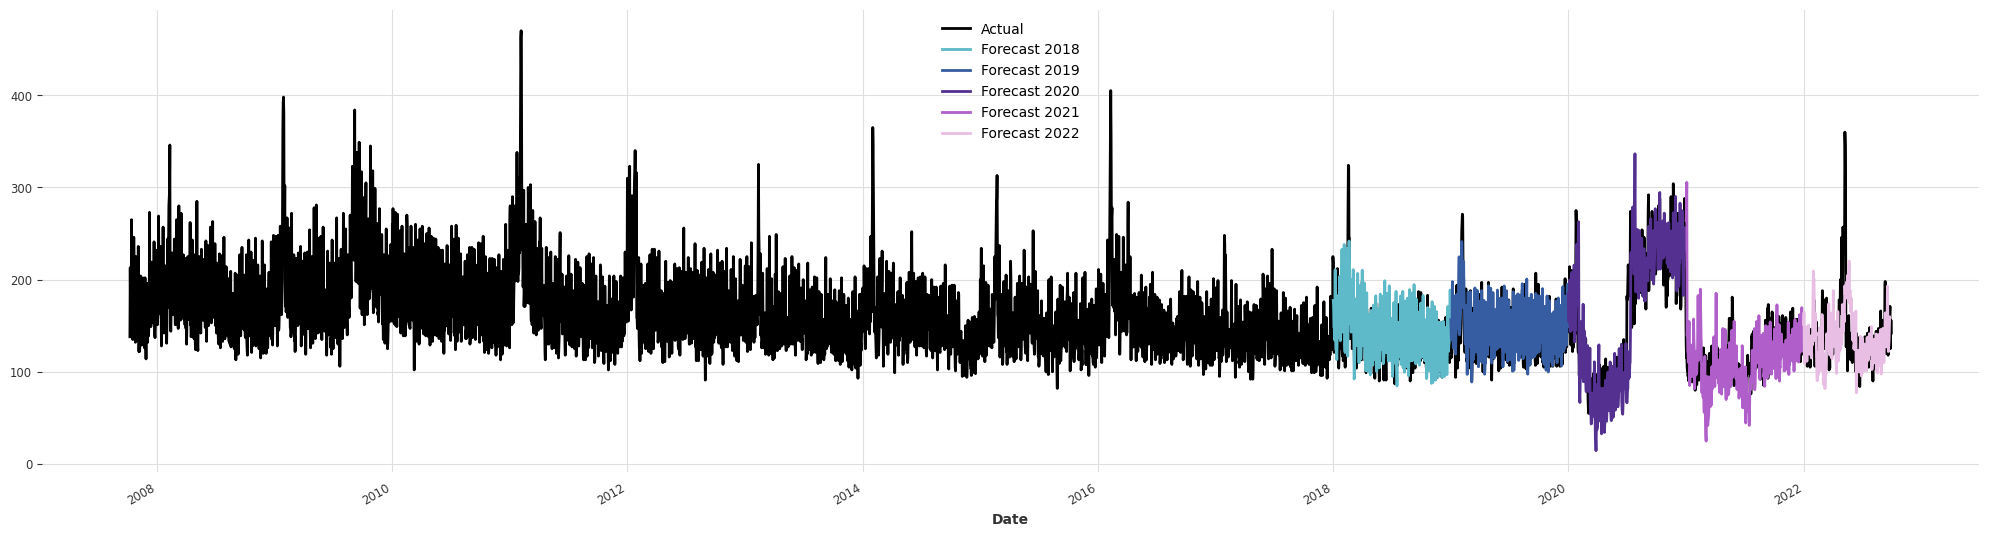

In [14]:
plt.figure(figsize=(25, 6))

# 绘制实际数据
combined_series.plot(label="Actual", color='black')

# 为2018到2022年的每个年份绘制预测数据
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']   # 为每个年份指定一个颜色
for i, year in enumerate(range(2018, 2023)):
    # 将DataArray转换回TimeSeries以便使用plot方法
    # 注意：这里假设yearly_dataarrays中存储的是DataArray对象
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    # 绘制每年的预测数据
    ts.plot(label=f"Forecast {year}", color=colors[i])

# 添加图例
plt.legend()

# 显示图表
plt.show()

#Save prediction

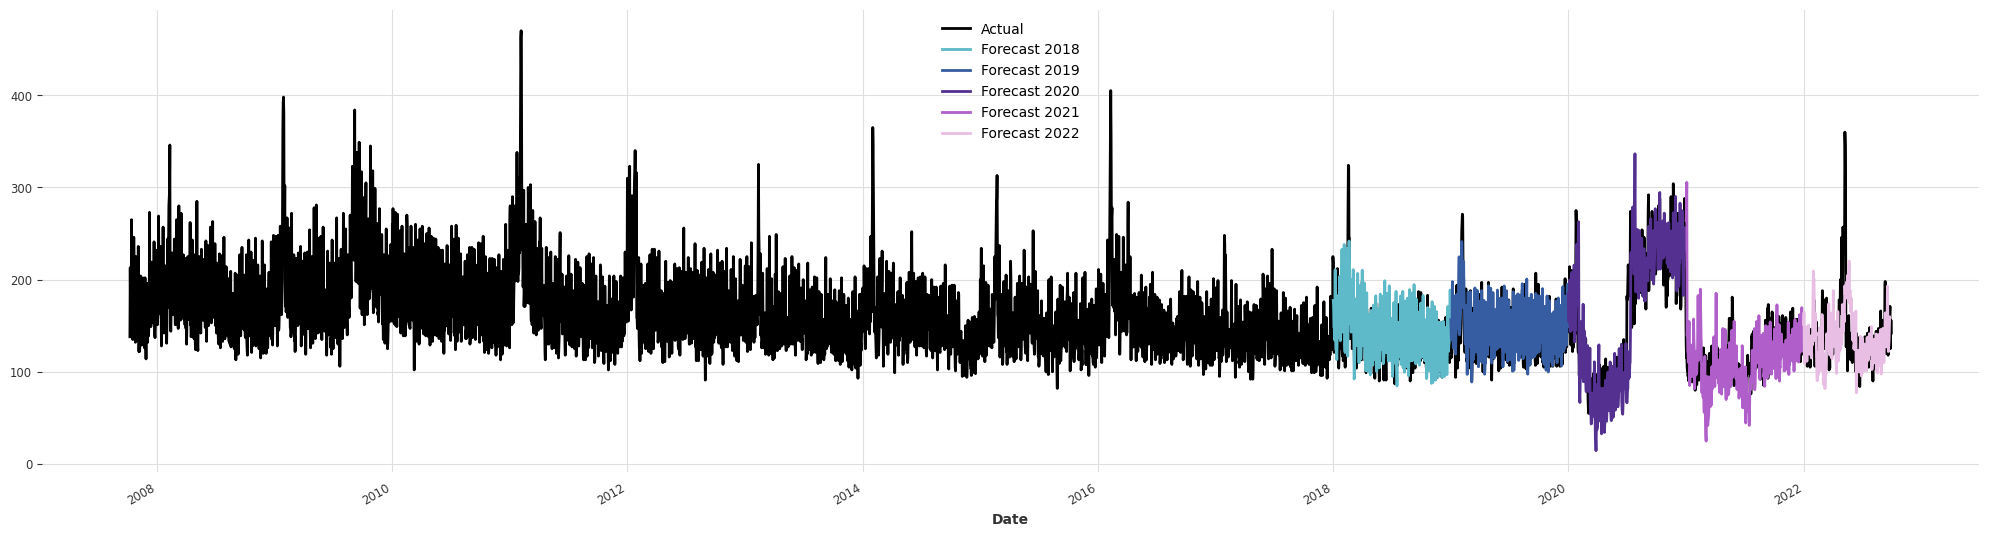

Forecast plot saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\DLinear\Taipei\Taipei_DLinear_FH7_forecast_plot.png
Metrics saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\DLinear\Taipei\Taipei_DLinear_FH7_metrics.txt
Model_prediction_df_inverse saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\DLinear\Taipei\Taipei_DLinear_FH7.csv


In [16]:
forecast_horizon_label = f"FH{forecast_horizon}"

# Define paths for the result files, using 'FH30' in the filenames
base_dir = os.path.abspath(os.path.join('..', 'Result', model_type, location))
plot_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_forecast_plot.png')
metrics_txt_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_metrics.txt')

# Ensure that the directories exist
os.makedirs(base_dir, exist_ok=True)

# Plot the actual and forecast data
plt.figure(figsize=(25, 6))

# Plot the actual data
combined_series.plot(label="Actual", color='black')

# Plot forecast data for each year (2018-2022)
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']
for i, year in enumerate(range(2018, 2023)):
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])  # Convert DataArray to TimeSeries
    ts.plot(label=f"Forecast {year}", color=colors[i])

# Add legend
plt.legend()

# Save the plot to the specified path BEFORE displaying it
plt.savefig(plot_path, bbox_inches='tight')

# Now display the plot
plt.show()

# Print confirmation
print(f"Forecast plot saved to {plot_path}")

# Calculate metrics and save them
metrics_result = calculate_metrics(combined_series, yearly_dataarrays, APEdf, calculate_95_ci)

if metrics_result is not None:
    with open(metrics_txt_path, 'w') as f:
        # Write location, model_type, and forecast_horizon each on a new line
        f.write(f"Location: {location}\n")
        f.write(f"Model: {model_type}\n")
        f.write(f"Forecast Horizon: {forecast_horizon_label}\n\n")
        
        # Write header with aligned columns
        f.write(f"{'Period':<25} | {'MAE':<8} | {'MAPE':<8} | {'APE 95% CI':<20}\n")
        f.write("-" * 65 + "\n")  # Separator line
        
        # Write each period's metrics in a single line, aligned
        for period, metric in metrics_result.items():
            if isinstance(metric['APE 95% CI'], tuple):
                f.write(f"{period:<25} | {metric['MAE']:<8.2f} | {metric['MAPE']:<7.2f}% | "
                        f"({metric['APE 95% CI'][0]:.2f}, {metric['APE 95% CI'][1]:.2f})\n")
            else:
                f.write(f"{period:<25} | {metric['MAE']:<8.2f} | {metric['MAPE']:<7.2f}% | "
                        f"APE 95% CI: N/A\n")
                
    print(f"Metrics saved to {metrics_txt_path}")
else:
    print("Metrics calculation returned None, so nothing was saved.")

# Save Model_prediction_df_inverse to CSV
csv_filename = f"{location}_{model_type}_{forecast_horizon_label}.csv"
csv_filepath = os.path.join(base_dir, csv_filename)
Model_prediction_df_inverse.to_csv(csv_filepath, index=True)

# Print confirmation
print(f"Model_prediction_df_inverse saved to {csv_filepath}")